#  Event generation with self-contrastive estimation

The aim of this notebook is to use self-contrastive estimation to learn the distribution of one observable, conditioned on one parameter, but written in a way which generalises to more observables and parameters.

In [1]:
#  Required imports
import os, time

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from   backends.stats import unwhiten_data, whiten_data
from   backends.utils import joint_shuffle, make_sure_dir_exists_for_filename
from   backends.Param import Param
from   backends       import models
from   backends.ParameterisedSimulator import ParameterisedSimulator, Simulator_Model2, Simulator_Model3
from   backends.SamplingSimulator      import SamplingSimulator

from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
#  Program constants

mu_scan_points = np.linspace(-2, 3, 5)

n_gen_points_per_c_per_ds        = 50000
n_noise_points_per_c_per_ds      = 100000
n_train_points_per_c_per_ds_true = 50000
n_train_points_per_c_per_ds_fake = 100000

train_batch_size            = 20000
max_epochs                  = 1000
dropout                     = 0.1

network_data_layers        = (20, 20)
network_condition_layers   = (5,)
network_combined_layers    = (40, 40, 40)
stopping_patience           = 20
iterate_same_network        = True
initial_noise_fraction      = 0.05

num_SCE_iterations = 100

plot_tag = None

In [3]:
#  Set up "true" model
model = Simulator_Model3

#  Generate several scan points for "true" model
xsections, datasets, weights = {}, {}, {}
for mu in mu_scan_points :
    model.set_param_value("c", mu)
    xsec, dataset = model.generate(n_gen_points_per_c_per_ds)
    xsections [mu] = xsec
    datasets  [mu] = dataset
    weights   [mu] = np.full(shape=(len(dataset),), fill_value=1./n_gen_points_per_c_per_ds)
    
#  Make sure one of the datasets was the SM
model.set_param_value("c", 0)
if 0 not in xsections :
    xsections [0], datasets [0] = model.generate(n_gen_points_per_c_per_ds)
    mu_scan_points = np.sort(np.concatenate([mu_scan_points, [0]]))
    weights [0] = np.full(shape=(len(dataset),), fill_value=1./n_gen_points_per_c_per_ds)
xsec_SM, dataset_SM, weights_SM = xsections[0], datasets[0], weights[0]

#  Whiten the data
white_datasets, whitening_params = whiten_data (datasets)
num_datasets = len(white_datasets)
print(f"Datasets generated for scan points: {', '.join([f'{mu:.3f}' for mu in mu_scan_points])}")

Datasets generated for scan points: -2.000, -0.750, 0.000, 0.500, 1.750, 3.000


In [4]:
def plot_dataset (mu_scan_points, xsections, datasets, weights=None, ref=None) :
    num_datasets = len(mu_scan_points)
           
    if type(weights) == type(None) :
        tmp_weights = {mu:np.full(fill_value=1./len(datasets[mu]), shape=(len(datasets[mu]),)) for mu in mu_scan_points}
    elif type(weights) == np.ndarray :
        tmp_weights = {mu:weights/np.sum(weights) for mu in mu_scan_points}
    elif type(weights) == dict : 
        tmp_weights = {mu:tmp_weights/np.sum(tmp_weights) for mu, tmp_weights in weights.items()}
    else :
        raise TypeError(f"Don't know what to do with weights of type {type(weights)}")
    
    plot_reference = False
    if type(ref) != type(None) :
        plot_reference = True
        xsections_ref, datasets_ref, weights_ref = ref
        
        if type(datasets_ref) == np.ndarray :
            tmp_datasets_ref = {mu:datasets_ref for mu in mu_scan_points}
        elif type(datasets_ref) == dict : 
            tmp_datasets_ref = datasets_ref
        else :
            raise TypeError(f"Don't know what to do with reference dataset of type {type(datasets_ref)}")
            
        if type(weights_ref) == type(None) :
            tmp_weights_ref = {mu:np.full(fill_value=1/len(tmp_datasets_ref[mu]), shape=(len(tmp_datasets_ref[mu]),)) for mu in mu_scan_points}
        elif type(weights_ref) == np.ndarray :
            tmp_weights_ref = {mu:weights_ref/np.sum(weights_ref) for mu in mu_scan_points}
        elif type(weights_ref) == dict : 
            tmp_weights_ref = {mu:tmp_weights_ref/np.sum(tmp_weights_ref) for mu, tmp_weights_ref in weights_ref.items()}
        else :
            raise TypeError(f"Don't know what to do with reference weights of type {type(weights_ref)}")
            
        if type(xsections_ref) == dict : 
            tmp_datasets_ref = datasets_ref
        else :
            tmp_datasets_ref = {mu:datasets_ref for mu in mu_scan_points}
        
        if type(xsections_ref) == type(None) :
            raise RuntimeError(f"Reference datasets must be provided reference cross sections too")
        if type(datasets_ref) == dict : 
            tmp_xsections_ref = xsections_ref
        else :
            tmp_xsections_ref = {mu:xsections_ref for mu in mu_scan_points}

    num_plot_rows = 6
    if plot_reference : num_plot_rows = 9
    
    fig = plt.figure(figsize=(4*num_datasets, 4*num_plot_rows))
    plot_row_idx = 0
    for ax_idx, mu in enumerate(mu_scan_points) :
        dataset = datasets  [mu]
        xsec    = xsections [mu]
        weight  = tmp_weights [mu]
        ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
        ax1.hist(dataset[:,0], alpha=0.5, weights=xsec*weight, fill=False, edgecolor="k", linestyle="-", linewidth=3)
        if plot_reference :
            dataset_ref = tmp_datasets_ref [mu]
            xsec_ref    = tmp_xsections_ref [mu]
            weight_ref  = tmp_weights_ref [mu]
            ax1.hist(dataset_ref[:,0], alpha=0.5, weights=xsec_ref*weight_ref, fill=True, color="r", linestyle="-", linewidth=3)
        ax1.set_title(f"$c = {mu:.3f}$", fontsize=30)
        if ax_idx > 0 : continue
        ax1.set_ylabel(r"$\frac{d\sigma}{dA}$", fontsize=30, rotation=0, labelpad=40)

    plot_row_idx = plot_row_idx + 1
    for ax_idx, mu in enumerate(mu_scan_points) :
        dataset = datasets  [mu]
        xsec    = xsections [mu]
        weight  = tmp_weights [mu]
        ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
        ax1.hist(dataset[:,1], alpha=0.5, weights=xsec*weight, fill=False, edgecolor="k", linestyle="-" , linewidth=3)
        if plot_reference :
            dataset_ref = tmp_datasets_ref [mu]
            xsec_ref    = tmp_xsections_ref [mu]
            weight_ref  = tmp_weights_ref [mu]
            ax1.hist(dataset_ref[:,1], alpha=0.5, weights=xsec_ref*weight_ref, fill=True, color="r", linestyle="-", linewidth=3)
        if ax_idx > 0 : continue
        ax1.set_ylabel(r"$\frac{d\sigma}{dB}$", fontsize=30, rotation=0, labelpad=40)

    plot_row_idx = plot_row_idx + 1
    for ax_idx, mu in enumerate(mu_scan_points) :
        dataset = datasets  [mu]
        xsec    = xsections [mu]
        weight  = tmp_weights [mu]
        ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
        ax1.hist(dataset[:,2], alpha=0.5, weights=xsec*weight, fill=False, edgecolor="k", linestyle="-" , linewidth=3)
        if plot_reference :
            dataset_ref = tmp_datasets_ref [mu]
            xsec_ref    = tmp_xsections_ref [mu]
            weight_ref  = tmp_weights_ref [mu]
            ax1.hist(dataset_ref[:,2], alpha=0.5, weights=xsec_ref*weight_ref, fill=True, color="r", linestyle="-", linewidth=3)
        if ax_idx > 0 : continue
        ax1.set_ylabel(r"$\frac{d\sigma}{dC}$", fontsize=30, rotation=0, labelpad=40)

    plot_row_idx = plot_row_idx + 1
    for ax_idx, mu in enumerate(mu_scan_points) :
        dataset = datasets [mu]
        weight  = tmp_weights [mu]
        ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
        ax1.hist2d(dataset[:,0], dataset[:,1], weights=weight)
        if ax_idx == 0 : 
            ax1.set_ylabel("$A$ \n / \n $B$", fontsize=30, rotation=0, labelpad=40)
    
    if plot_reference :
        plot_row_idx = plot_row_idx + 1
        for ax_idx, mu in enumerate(mu_scan_points) :
            dataset = tmp_datasets_ref [mu]
            weight  = tmp_weights_ref [mu]
            ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
            ax1.hist2d(dataset[:,0], dataset[:,1], weights=weight)
            if ax_idx == 0 : 
                ax1.set_ylabel("$A$ \n / \n $B$ \n ref", fontsize=30, rotation=0, labelpad=40, va="center")

    plot_row_idx = plot_row_idx + 1
    for ax_idx, mu in enumerate(mu_scan_points) :
        dataset = datasets [mu]
        weight  = tmp_weights [mu]
        ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
        ax1.hist2d(dataset[:,0], dataset[:,2], weights=weight)
        if ax_idx == 0 : 
            ax1.set_ylabel("$A$ \n / \n $C$", fontsize=30, rotation=0, labelpad=40)
    
    if plot_reference :
        plot_row_idx = plot_row_idx + 1
        for ax_idx, mu in enumerate(mu_scan_points) :
            dataset = tmp_datasets_ref [mu]
            weight  = tmp_weights_ref [mu]
            ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
            ax1.hist2d(dataset[:,0], dataset[:,2], weights=weight)
            if ax_idx == 0 : 
                ax1.set_ylabel("$A$ \n / \n $C$ \n ref", fontsize=30, rotation=0, labelpad=40, va="center")

    plot_row_idx = plot_row_idx + 1
    for ax_idx, mu in enumerate(mu_scan_points) :
        dataset = datasets [mu]
        weight  = tmp_weights [mu]
        ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
        ax1.hist2d(dataset[:,1], dataset[:,2], weights=weight)
        if ax_idx == 0 : 
            ax1.set_ylabel("$B$ \n / \n $C$", fontsize=30, rotation=0, labelpad=40)
    
    if plot_reference :
        plot_row_idx = plot_row_idx + 1
        for ax_idx, mu in enumerate(mu_scan_points) :
            dataset = tmp_datasets_ref [mu]
            weight  = tmp_weights_ref [mu]
            ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
            ax1.hist2d(dataset[:,1], dataset[:,2], weights=weight)
            if ax_idx == 0 : 
                ax1.set_ylabel("$B$ \n / \n $C$ \n ref", fontsize=30, rotation=0, labelpad=40, va="center")
                
    plt.show()


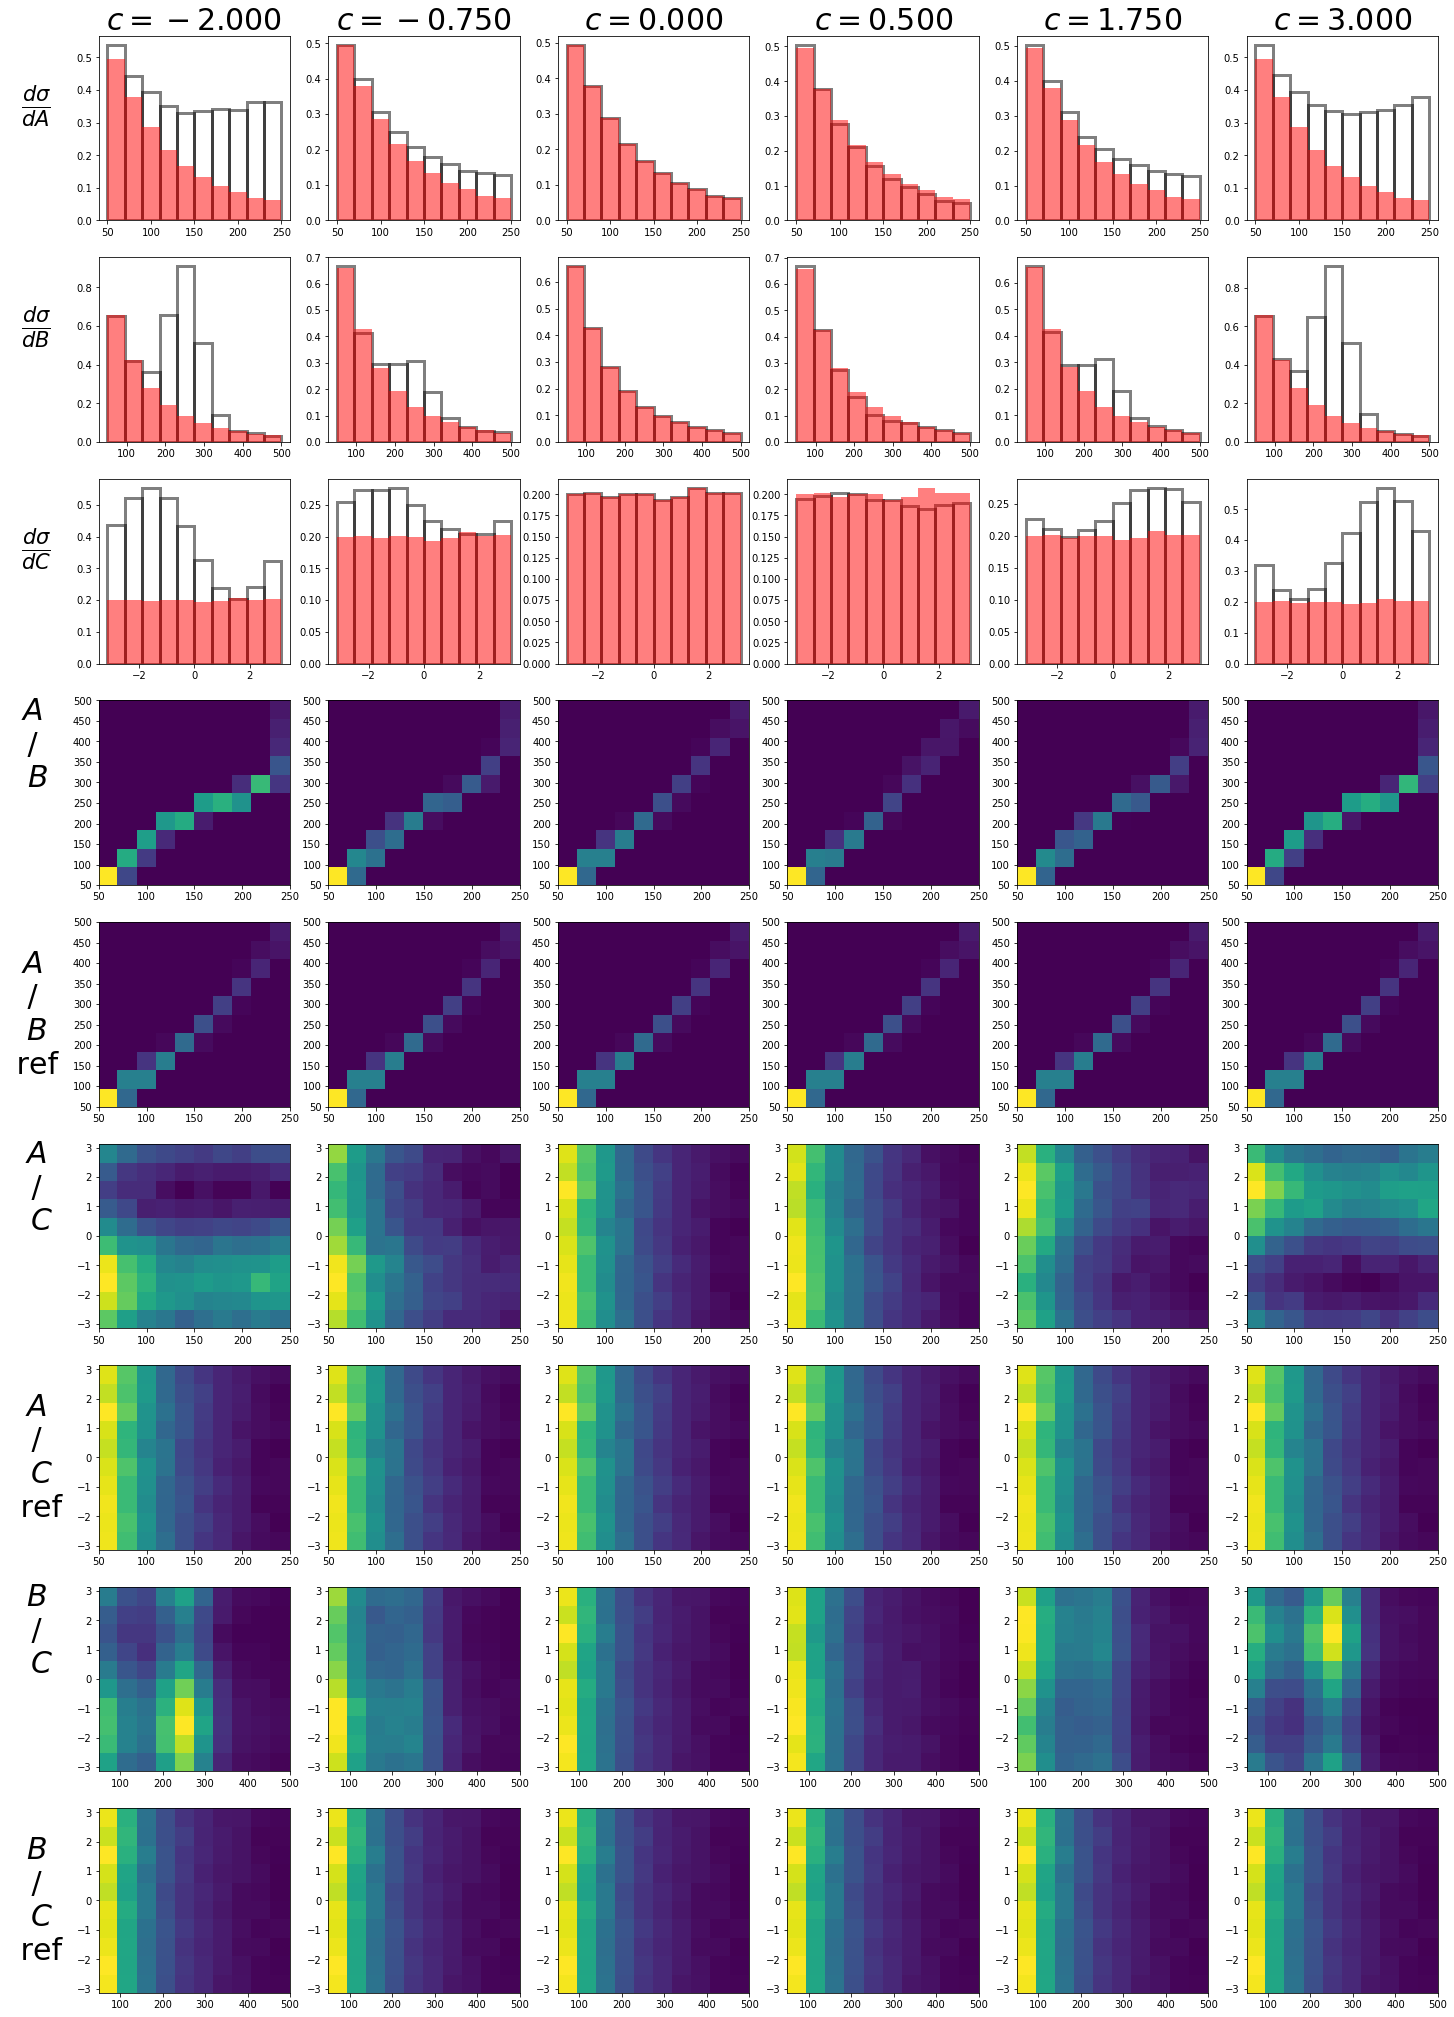

In [5]:
plot_dataset(mu_scan_points, xsections, datasets, weights, ref=(xsec_SM, dataset_SM, weights_SM))

In [6]:
xsec_model = models.create_simple_model(dropout         = -1,
                                        sigmoid         = True,
                                        name            = "xsec_model",
                                        num_outputs     = 1,
                                        num_observables = 1,
                                        layers          = (20,),
                                        verbose         = False)
train_X = mu_scan_points
train_Y = [xsections[mu] for mu in mu_scan_points]
xsec_model.fit(train_X,
               train_Y,
               epochs=1000000,
               callbacks=[EarlyStopping(restore_best_weights=True, monitor="loss", patience=100, min_delta=1e-5)])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000000
6/6 [==============================] - 0s 13ms/step - loss: 13.4539
Epoch 2/1000000
6/6 [==============================] - 0s 175us/step - loss: 13.4022
Epoch 3/1000000
6/6 [==============================] - 0s 164us/step - loss: 13.3507
Epoch 4/1000000
6/6 [==============================] - 0s 160us/step - loss: 13.2993
Epoch 5/1000000
6/6 [==============================] - 0s 155us/step - loss: 13.2480
Epoch 6/1000000
6/6 [==============================] - 0s 165us/step - loss: 13.1969
Epoch 7/1000000
6/6 [==============================] - 0s 156us/step - loss: 13.1459
Epoch 8/1000000
6/6 [==============================] - 0s 179us/step - loss: 13.0950
Epoch 9/1000000
6/6 [==============================] - 0s 163us/step - loss: 13.0443
Epoch 10/1000000
6/6 [==============================] - 0s 163us/step - loss: 12.9937
Epoch 11/1000000
6/6 [========

Epoch 91/1000000
6/6 [==============================] - 0s 160us/step - loss: 9.4119
Epoch 92/1000000
6/6 [==============================] - 0s 145us/step - loss: 9.3739
Epoch 93/1000000
6/6 [==============================] - 0s 154us/step - loss: 9.3359
Epoch 94/1000000
6/6 [==============================] - 0s 148us/step - loss: 9.2981
Epoch 95/1000000
6/6 [==============================] - 0s 136us/step - loss: 9.2604
Epoch 96/1000000
6/6 [==============================] - 0s 152us/step - loss: 9.2228
Epoch 97/1000000
6/6 [==============================] - 0s 143us/step - loss: 9.1854
Epoch 98/1000000
6/6 [==============================] - 0s 153us/step - loss: 9.1481
Epoch 99/1000000
6/6 [==============================] - 0s 149us/step - loss: 9.1110
Epoch 100/1000000
6/6 [==============================] - 0s 151us/step - loss: 9.0740
Epoch 101/1000000
6/6 [==============================] - 0s 174us/step - loss: 9.0371
Epoch 102/1000000
6/6 [==============================] - 0s 157

Epoch 187/1000000
6/6 [==============================] - 0s 150us/step - loss: 6.3052
Epoch 188/1000000
6/6 [==============================] - 0s 164us/step - loss: 6.2780
Epoch 189/1000000
6/6 [==============================] - 0s 148us/step - loss: 6.2509
Epoch 190/1000000
6/6 [==============================] - 0s 152us/step - loss: 6.2240
Epoch 191/1000000
6/6 [==============================] - 0s 157us/step - loss: 6.1971
Epoch 192/1000000
6/6 [==============================] - 0s 150us/step - loss: 6.1704
Epoch 193/1000000
6/6 [==============================] - 0s 152us/step - loss: 6.1437
Epoch 194/1000000
6/6 [==============================] - 0s 144us/step - loss: 6.1171
Epoch 195/1000000
6/6 [==============================] - 0s 148us/step - loss: 6.0906
Epoch 196/1000000
6/6 [==============================] - 0s 137us/step - loss: 6.0642
Epoch 197/1000000
6/6 [==============================] - 0s 154us/step - loss: 6.0379
Epoch 198/1000000
6/6 [==============================]

Epoch 283/1000000
6/6 [==============================] - 0s 150us/step - loss: 4.1036
Epoch 284/1000000
6/6 [==============================] - 0s 155us/step - loss: 4.0847
Epoch 285/1000000
6/6 [==============================] - 0s 184us/step - loss: 4.0658
Epoch 286/1000000
6/6 [==============================] - 0s 146us/step - loss: 4.0470
Epoch 287/1000000
6/6 [==============================] - 0s 133us/step - loss: 4.0283
Epoch 288/1000000
6/6 [==============================] - 0s 143us/step - loss: 4.0097
Epoch 289/1000000
6/6 [==============================] - 0s 145us/step - loss: 3.9911
Epoch 290/1000000
6/6 [==============================] - 0s 139us/step - loss: 3.9727
Epoch 291/1000000
6/6 [==============================] - 0s 163us/step - loss: 3.9543
Epoch 292/1000000
6/6 [==============================] - 0s 153us/step - loss: 3.9360
Epoch 293/1000000
6/6 [==============================] - 0s 171us/step - loss: 3.9177
Epoch 294/1000000
6/6 [==============================]

Epoch 379/1000000
6/6 [==============================] - 0s 174us/step - loss: 2.6119
Epoch 380/1000000
6/6 [==============================] - 0s 138us/step - loss: 2.5996
Epoch 381/1000000
6/6 [==============================] - 0s 155us/step - loss: 2.5873
Epoch 382/1000000
6/6 [==============================] - 0s 159us/step - loss: 2.5751
Epoch 383/1000000
6/6 [==============================] - 0s 157us/step - loss: 2.5629
Epoch 384/1000000
6/6 [==============================] - 0s 150us/step - loss: 2.5508
Epoch 385/1000000
6/6 [==============================] - 0s 150us/step - loss: 2.5388
Epoch 386/1000000
6/6 [==============================] - 0s 193us/step - loss: 2.5268
Epoch 387/1000000
6/6 [==============================] - 0s 164us/step - loss: 2.5149
Epoch 388/1000000
6/6 [==============================] - 0s 142us/step - loss: 2.5030
Epoch 389/1000000
6/6 [==============================] - 0s 159us/step - loss: 2.4912
Epoch 390/1000000
6/6 [==============================]

Epoch 475/1000000
6/6 [==============================] - 0s 196us/step - loss: 1.6741
Epoch 476/1000000
6/6 [==============================] - 0s 171us/step - loss: 1.6667
Epoch 477/1000000
6/6 [==============================] - 0s 163us/step - loss: 1.6593
Epoch 478/1000000
6/6 [==============================] - 0s 157us/step - loss: 1.6520
Epoch 479/1000000
6/6 [==============================] - 0s 146us/step - loss: 1.6447
Epoch 480/1000000
6/6 [==============================] - 0s 147us/step - loss: 1.6374
Epoch 481/1000000
6/6 [==============================] - 0s 165us/step - loss: 1.6302
Epoch 482/1000000
6/6 [==============================] - 0s 177us/step - loss: 1.6230
Epoch 483/1000000
6/6 [==============================] - 0s 143us/step - loss: 1.6159
Epoch 484/1000000
6/6 [==============================] - 0s 159us/step - loss: 1.6088
Epoch 485/1000000
6/6 [==============================] - 0s 167us/step - loss: 1.6017
Epoch 486/1000000
6/6 [==============================]

Epoch 571/1000000
6/6 [==============================] - 0s 156us/step - loss: 1.1303
Epoch 572/1000000
6/6 [==============================] - 0s 151us/step - loss: 1.1262
Epoch 573/1000000
6/6 [==============================] - 0s 141us/step - loss: 1.1221
Epoch 574/1000000
6/6 [==============================] - 0s 187us/step - loss: 1.1180
Epoch 575/1000000
6/6 [==============================] - 0s 187us/step - loss: 1.1140
Epoch 576/1000000
6/6 [==============================] - 0s 184us/step - loss: 1.1100
Epoch 577/1000000
6/6 [==============================] - 0s 160us/step - loss: 1.1060
Epoch 578/1000000
6/6 [==============================] - 0s 156us/step - loss: 1.1021
Epoch 579/1000000
6/6 [==============================] - 0s 168us/step - loss: 1.0982
Epoch 580/1000000
6/6 [==============================] - 0s 160us/step - loss: 1.0943
Epoch 581/1000000
6/6 [==============================] - 0s 174us/step - loss: 1.0904
Epoch 582/1000000
6/6 [==============================]

Epoch 667/1000000
6/6 [==============================] - 0s 160us/step - loss: 0.8410
Epoch 668/1000000
6/6 [==============================] - 0s 146us/step - loss: 0.8389
Epoch 669/1000000
6/6 [==============================] - 0s 181us/step - loss: 0.8368
Epoch 670/1000000
6/6 [==============================] - 0s 162us/step - loss: 0.8348
Epoch 671/1000000
6/6 [==============================] - 0s 156us/step - loss: 0.8327
Epoch 672/1000000
6/6 [==============================] - 0s 182us/step - loss: 0.8307
Epoch 673/1000000
6/6 [==============================] - 0s 165us/step - loss: 0.8287
Epoch 674/1000000
6/6 [==============================] - 0s 199us/step - loss: 0.8267
Epoch 675/1000000
6/6 [==============================] - 0s 175us/step - loss: 0.8248
Epoch 676/1000000
6/6 [==============================] - 0s 173us/step - loss: 0.8228
Epoch 677/1000000
6/6 [==============================] - 0s 201us/step - loss: 0.8209
Epoch 678/1000000
6/6 [==============================]

Epoch 763/1000000
6/6 [==============================] - 0s 214us/step - loss: 0.7004
Epoch 764/1000000
6/6 [==============================] - 0s 148us/step - loss: 0.6995
Epoch 765/1000000
6/6 [==============================] - 0s 168us/step - loss: 0.6985
Epoch 766/1000000
6/6 [==============================] - 0s 162us/step - loss: 0.6976
Epoch 767/1000000
6/6 [==============================] - 0s 187us/step - loss: 0.6966
Epoch 768/1000000
6/6 [==============================] - 0s 172us/step - loss: 0.6957
Epoch 769/1000000
6/6 [==============================] - 0s 171us/step - loss: 0.6948
Epoch 770/1000000
6/6 [==============================] - 0s 164us/step - loss: 0.6939
Epoch 771/1000000
6/6 [==============================] - 0s 166us/step - loss: 0.6930
Epoch 772/1000000
6/6 [==============================] - 0s 144us/step - loss: 0.6921
Epoch 773/1000000
6/6 [==============================] - 0s 160us/step - loss: 0.6912
Epoch 774/1000000
6/6 [==============================]

Epoch 859/1000000
6/6 [==============================] - 0s 171us/step - loss: 0.6376
Epoch 860/1000000
6/6 [==============================] - 0s 149us/step - loss: 0.6372
Epoch 861/1000000
6/6 [==============================] - 0s 180us/step - loss: 0.6368
Epoch 862/1000000
6/6 [==============================] - 0s 151us/step - loss: 0.6364
Epoch 863/1000000
6/6 [==============================] - 0s 163us/step - loss: 0.6360
Epoch 864/1000000
6/6 [==============================] - 0s 214us/step - loss: 0.6356
Epoch 865/1000000
6/6 [==============================] - 0s 155us/step - loss: 0.6352
Epoch 866/1000000
6/6 [==============================] - 0s 140us/step - loss: 0.6348
Epoch 867/1000000
6/6 [==============================] - 0s 153us/step - loss: 0.6344
Epoch 868/1000000
6/6 [==============================] - 0s 190us/step - loss: 0.6341
Epoch 869/1000000
6/6 [==============================] - 0s 149us/step - loss: 0.6337
Epoch 870/1000000
6/6 [==============================]

Epoch 955/1000000
6/6 [==============================] - 0s 165us/step - loss: 0.6109
Epoch 956/1000000
6/6 [==============================] - 0s 154us/step - loss: 0.6107
Epoch 957/1000000
6/6 [==============================] - 0s 157us/step - loss: 0.6106
Epoch 958/1000000
6/6 [==============================] - 0s 140us/step - loss: 0.6104
Epoch 959/1000000
6/6 [==============================] - 0s 172us/step - loss: 0.6102
Epoch 960/1000000
6/6 [==============================] - 0s 147us/step - loss: 0.6101
Epoch 961/1000000
6/6 [==============================] - 0s 178us/step - loss: 0.6099
Epoch 962/1000000
6/6 [==============================] - 0s 154us/step - loss: 0.6097
Epoch 963/1000000
6/6 [==============================] - 0s 195us/step - loss: 0.6095
Epoch 964/1000000
6/6 [==============================] - 0s 168us/step - loss: 0.6094
Epoch 965/1000000
6/6 [==============================] - 0s 183us/step - loss: 0.6092
Epoch 966/1000000
6/6 [==============================]

Epoch 1050/1000000
6/6 [==============================] - 0s 170us/step - loss: 0.5991
Epoch 1051/1000000
6/6 [==============================] - 0s 190us/step - loss: 0.5990
Epoch 1052/1000000
6/6 [==============================] - 0s 208us/step - loss: 0.5989
Epoch 1053/1000000
6/6 [==============================] - 0s 172us/step - loss: 0.5988
Epoch 1054/1000000
6/6 [==============================] - 0s 220us/step - loss: 0.5988
Epoch 1055/1000000
6/6 [==============================] - 0s 159us/step - loss: 0.5987
Epoch 1056/1000000
6/6 [==============================] - 0s 297us/step - loss: 0.5986
Epoch 1057/1000000
6/6 [==============================] - 0s 199us/step - loss: 0.5985
Epoch 1058/1000000
6/6 [==============================] - 0s 209us/step - loss: 0.5984
Epoch 1059/1000000
6/6 [==============================] - 0s 239us/step - loss: 0.5983
Epoch 1060/1000000
6/6 [==============================] - 0s 170us/step - loss: 0.5983
Epoch 1061/1000000
6/6 [===================

6/6 [==============================] - 0s 196us/step - loss: 0.5926
Epoch 1145/1000000
6/6 [==============================] - 0s 171us/step - loss: 0.5926
Epoch 1146/1000000
6/6 [==============================] - 0s 170us/step - loss: 0.5925
Epoch 1147/1000000
6/6 [==============================] - 0s 174us/step - loss: 0.5925
Epoch 1148/1000000
6/6 [==============================] - 0s 210us/step - loss: 0.5924
Epoch 1149/1000000
6/6 [==============================] - 0s 178us/step - loss: 0.5924
Epoch 1150/1000000
6/6 [==============================] - 0s 178us/step - loss: 0.5923
Epoch 1151/1000000
6/6 [==============================] - 0s 154us/step - loss: 0.5923
Epoch 1152/1000000
6/6 [==============================] - 0s 129us/step - loss: 0.5922
Epoch 1153/1000000
6/6 [==============================] - 0s 187us/step - loss: 0.5921
Epoch 1154/1000000
6/6 [==============================] - 0s 141us/step - loss: 0.5921
Epoch 1155/1000000
6/6 [==============================] - 0s 1

Epoch 1239/1000000
6/6 [==============================] - 0s 163us/step - loss: 0.5878
Epoch 1240/1000000
6/6 [==============================] - 0s 160us/step - loss: 0.5878
Epoch 1241/1000000
6/6 [==============================] - 0s 177us/step - loss: 0.5877
Epoch 1242/1000000
6/6 [==============================] - 0s 182us/step - loss: 0.5877
Epoch 1243/1000000
6/6 [==============================] - 0s 146us/step - loss: 0.5876
Epoch 1244/1000000
6/6 [==============================] - 0s 164us/step - loss: 0.5876
Epoch 1245/1000000
6/6 [==============================] - 0s 171us/step - loss: 0.5875
Epoch 1246/1000000
6/6 [==============================] - 0s 209us/step - loss: 0.5875
Epoch 1247/1000000
6/6 [==============================] - 0s 191us/step - loss: 0.5874
Epoch 1248/1000000
6/6 [==============================] - 0s 190us/step - loss: 0.5874
Epoch 1249/1000000
6/6 [==============================] - 0s 145us/step - loss: 0.5873
Epoch 1250/1000000
6/6 [===================

6/6 [==============================] - 0s 150us/step - loss: 0.5834
Epoch 1334/1000000
6/6 [==============================] - 0s 148us/step - loss: 0.5833
Epoch 1335/1000000
6/6 [==============================] - 0s 158us/step - loss: 0.5833
Epoch 1336/1000000
6/6 [==============================] - 0s 161us/step - loss: 0.5833
Epoch 1337/1000000
6/6 [==============================] - 0s 164us/step - loss: 0.5832
Epoch 1338/1000000
6/6 [==============================] - 0s 176us/step - loss: 0.5832
Epoch 1339/1000000
6/6 [==============================] - 0s 155us/step - loss: 0.5831
Epoch 1340/1000000
6/6 [==============================] - 0s 175us/step - loss: 0.5831
Epoch 1341/1000000
6/6 [==============================] - 0s 206us/step - loss: 0.5830
Epoch 1342/1000000
6/6 [==============================] - 0s 152us/step - loss: 0.5830
Epoch 1343/1000000
6/6 [==============================] - 0s 153us/step - loss: 0.5829
Epoch 1344/1000000
6/6 [==============================] - 0s 1

Epoch 1428/1000000
6/6 [==============================] - 0s 164us/step - loss: 0.5789
Epoch 1429/1000000
6/6 [==============================] - 0s 237us/step - loss: 0.5788
Epoch 1430/1000000
6/6 [==============================] - 0s 169us/step - loss: 0.5788
Epoch 1431/1000000
6/6 [==============================] - 0s 216us/step - loss: 0.5787
Epoch 1432/1000000
6/6 [==============================] - 0s 172us/step - loss: 0.5787
Epoch 1433/1000000
6/6 [==============================] - 0s 210us/step - loss: 0.5786
Epoch 1434/1000000
6/6 [==============================] - 0s 208us/step - loss: 0.5786
Epoch 1435/1000000
6/6 [==============================] - 0s 193us/step - loss: 0.5785
Epoch 1436/1000000
6/6 [==============================] - 0s 170us/step - loss: 0.5785
Epoch 1437/1000000
6/6 [==============================] - 0s 184us/step - loss: 0.5784
Epoch 1438/1000000
6/6 [==============================] - 0s 157us/step - loss: 0.5784
Epoch 1439/1000000
6/6 [===================

Epoch 1523/1000000
6/6 [==============================] - 0s 161us/step - loss: 0.5741
Epoch 1524/1000000
6/6 [==============================] - 0s 179us/step - loss: 0.5741
Epoch 1525/1000000
6/6 [==============================] - 0s 160us/step - loss: 0.5740
Epoch 1526/1000000
6/6 [==============================] - 0s 157us/step - loss: 0.5740
Epoch 1527/1000000
6/6 [==============================] - 0s 158us/step - loss: 0.5739
Epoch 1528/1000000
6/6 [==============================] - 0s 170us/step - loss: 0.5739
Epoch 1529/1000000
6/6 [==============================] - 0s 162us/step - loss: 0.5738
Epoch 1530/1000000
6/6 [==============================] - 0s 162us/step - loss: 0.5738
Epoch 1531/1000000
6/6 [==============================] - 0s 158us/step - loss: 0.5737
Epoch 1532/1000000
6/6 [==============================] - 0s 161us/step - loss: 0.5737
Epoch 1533/1000000
6/6 [==============================] - 0s 152us/step - loss: 0.5736
Epoch 1534/1000000
6/6 [===================

6/6 [==============================] - 0s 154us/step - loss: 0.5691
Epoch 1618/1000000
6/6 [==============================] - 0s 162us/step - loss: 0.5691
Epoch 1619/1000000
6/6 [==============================] - 0s 163us/step - loss: 0.5690
Epoch 1620/1000000
6/6 [==============================] - 0s 184us/step - loss: 0.5690
Epoch 1621/1000000
6/6 [==============================] - 0s 153us/step - loss: 0.5689
Epoch 1622/1000000
6/6 [==============================] - 0s 164us/step - loss: 0.5689
Epoch 1623/1000000
6/6 [==============================] - 0s 166us/step - loss: 0.5688
Epoch 1624/1000000
6/6 [==============================] - 0s 168us/step - loss: 0.5688
Epoch 1625/1000000
6/6 [==============================] - 0s 166us/step - loss: 0.5687
Epoch 1626/1000000
6/6 [==============================] - 0s 171us/step - loss: 0.5687
Epoch 1627/1000000
6/6 [==============================] - 0s 180us/step - loss: 0.5686
Epoch 1628/1000000
6/6 [==============================] - 0s 1

Epoch 1712/1000000
6/6 [==============================] - 0s 148us/step - loss: 0.5638
Epoch 1713/1000000
6/6 [==============================] - 0s 174us/step - loss: 0.5637
Epoch 1714/1000000
6/6 [==============================] - 0s 154us/step - loss: 0.5636
Epoch 1715/1000000
6/6 [==============================] - 0s 156us/step - loss: 0.5636
Epoch 1716/1000000
6/6 [==============================] - 0s 163us/step - loss: 0.5635
Epoch 1717/1000000
6/6 [==============================] - 0s 151us/step - loss: 0.5635
Epoch 1718/1000000
6/6 [==============================] - 0s 171us/step - loss: 0.5634
Epoch 1719/1000000
6/6 [==============================] - 0s 178us/step - loss: 0.5633
Epoch 1720/1000000
6/6 [==============================] - 0s 150us/step - loss: 0.5633
Epoch 1721/1000000
6/6 [==============================] - 0s 171us/step - loss: 0.5632
Epoch 1722/1000000
6/6 [==============================] - 0s 145us/step - loss: 0.5632
Epoch 1723/1000000
6/6 [===================

6/6 [==============================] - 0s 160us/step - loss: 0.5580
Epoch 1807/1000000
6/6 [==============================] - 0s 171us/step - loss: 0.5580
Epoch 1808/1000000
6/6 [==============================] - 0s 202us/step - loss: 0.5579
Epoch 1809/1000000
6/6 [==============================] - 0s 174us/step - loss: 0.5578
Epoch 1810/1000000
6/6 [==============================] - 0s 153us/step - loss: 0.5578
Epoch 1811/1000000
6/6 [==============================] - 0s 196us/step - loss: 0.5577
Epoch 1812/1000000
6/6 [==============================] - 0s 157us/step - loss: 0.5576
Epoch 1813/1000000
6/6 [==============================] - 0s 158us/step - loss: 0.5576
Epoch 1814/1000000
6/6 [==============================] - 0s 167us/step - loss: 0.5575
Epoch 1815/1000000
6/6 [==============================] - 0s 147us/step - loss: 0.5575
Epoch 1816/1000000
6/6 [==============================] - 0s 186us/step - loss: 0.5574
Epoch 1817/1000000
6/6 [==============================] - 0s 1

Epoch 1901/1000000
6/6 [==============================] - 0s 208us/step - loss: 0.5518
Epoch 1902/1000000
6/6 [==============================] - 0s 155us/step - loss: 0.5517
Epoch 1903/1000000
6/6 [==============================] - 0s 158us/step - loss: 0.5517
Epoch 1904/1000000
6/6 [==============================] - 0s 170us/step - loss: 0.5516
Epoch 1905/1000000
6/6 [==============================] - 0s 151us/step - loss: 0.5515
Epoch 1906/1000000
6/6 [==============================] - 0s 163us/step - loss: 0.5514
Epoch 1907/1000000
6/6 [==============================] - 0s 153us/step - loss: 0.5514
Epoch 1908/1000000
6/6 [==============================] - 0s 165us/step - loss: 0.5513
Epoch 1909/1000000
6/6 [==============================] - 0s 154us/step - loss: 0.5512
Epoch 1910/1000000
6/6 [==============================] - 0s 185us/step - loss: 0.5512
Epoch 1911/1000000
6/6 [==============================] - 0s 190us/step - loss: 0.5511
Epoch 1912/1000000
6/6 [===================

6/6 [==============================] - 0s 163us/step - loss: 0.5451
Epoch 1996/1000000
6/6 [==============================] - 0s 184us/step - loss: 0.5451
Epoch 1997/1000000
6/6 [==============================] - 0s 163us/step - loss: 0.5450
Epoch 1998/1000000
6/6 [==============================] - 0s 166us/step - loss: 0.5449
Epoch 1999/1000000
6/6 [==============================] - 0s 201us/step - loss: 0.5449
Epoch 2000/1000000
6/6 [==============================] - 0s 148us/step - loss: 0.5448
Epoch 2001/1000000
6/6 [==============================] - 0s 167us/step - loss: 0.5447
Epoch 2002/1000000
6/6 [==============================] - 0s 179us/step - loss: 0.5446
Epoch 2003/1000000
6/6 [==============================] - 0s 157us/step - loss: 0.5446
Epoch 2004/1000000
6/6 [==============================] - 0s 154us/step - loss: 0.5445
Epoch 2005/1000000
6/6 [==============================] - 0s 186us/step - loss: 0.5444
Epoch 2006/1000000
6/6 [==============================] - 0s 1

Epoch 2090/1000000
6/6 [==============================] - 0s 183us/step - loss: 0.5379
Epoch 2091/1000000
6/6 [==============================] - 0s 199us/step - loss: 0.5378
Epoch 2092/1000000
6/6 [==============================] - 0s 183us/step - loss: 0.5378
Epoch 2093/1000000
6/6 [==============================] - 0s 154us/step - loss: 0.5377
Epoch 2094/1000000
6/6 [==============================] - 0s 289us/step - loss: 0.5376
Epoch 2095/1000000
6/6 [==============================] - 0s 150us/step - loss: 0.5375
Epoch 2096/1000000
6/6 [==============================] - 0s 173us/step - loss: 0.5374
Epoch 2097/1000000
6/6 [==============================] - 0s 172us/step - loss: 0.5374
Epoch 2098/1000000
6/6 [==============================] - 0s 164us/step - loss: 0.5373
Epoch 2099/1000000
6/6 [==============================] - 0s 146us/step - loss: 0.5372
Epoch 2100/1000000
6/6 [==============================] - 0s 212us/step - loss: 0.5371
Epoch 2101/1000000
6/6 [===================

Epoch 2185/1000000
6/6 [==============================] - 0s 138us/step - loss: 0.5301
Epoch 2186/1000000
6/6 [==============================] - 0s 166us/step - loss: 0.5300
Epoch 2187/1000000
6/6 [==============================] - 0s 170us/step - loss: 0.5300
Epoch 2188/1000000
6/6 [==============================] - 0s 169us/step - loss: 0.5299
Epoch 2189/1000000
6/6 [==============================] - 0s 185us/step - loss: 0.5298
Epoch 2190/1000000
6/6 [==============================] - 0s 139us/step - loss: 0.5297
Epoch 2191/1000000
6/6 [==============================] - 0s 182us/step - loss: 0.5296
Epoch 2192/1000000
6/6 [==============================] - 0s 167us/step - loss: 0.5295
Epoch 2193/1000000
6/6 [==============================] - 0s 184us/step - loss: 0.5294
Epoch 2194/1000000
6/6 [==============================] - 0s 165us/step - loss: 0.5294
Epoch 2195/1000000
6/6 [==============================] - 0s 200us/step - loss: 0.5293
Epoch 2196/1000000
6/6 [===================

6/6 [==============================] - 0s 171us/step - loss: 0.5218
Epoch 2280/1000000
6/6 [==============================] - 0s 180us/step - loss: 0.5218
Epoch 2281/1000000
6/6 [==============================] - 0s 152us/step - loss: 0.5217
Epoch 2282/1000000
6/6 [==============================] - 0s 168us/step - loss: 0.5216
Epoch 2283/1000000
6/6 [==============================] - 0s 141us/step - loss: 0.5215
Epoch 2284/1000000
6/6 [==============================] - 0s 162us/step - loss: 0.5214
Epoch 2285/1000000
6/6 [==============================] - 0s 221us/step - loss: 0.5213
Epoch 2286/1000000
6/6 [==============================] - 0s 156us/step - loss: 0.5212
Epoch 2287/1000000
6/6 [==============================] - 0s 150us/step - loss: 0.5211
Epoch 2288/1000000
6/6 [==============================] - 0s 204us/step - loss: 0.5210
Epoch 2289/1000000
6/6 [==============================] - 0s 162us/step - loss: 0.5209
Epoch 2290/1000000
6/6 [==============================] - 0s 1

Epoch 2374/1000000
6/6 [==============================] - 0s 195us/step - loss: 0.5129
Epoch 2375/1000000
6/6 [==============================] - 0s 148us/step - loss: 0.5128
Epoch 2376/1000000
6/6 [==============================] - 0s 145us/step - loss: 0.5127
Epoch 2377/1000000
6/6 [==============================] - 0s 316us/step - loss: 0.5126
Epoch 2378/1000000
6/6 [==============================] - 0s 252us/step - loss: 0.5125
Epoch 2379/1000000
6/6 [==============================] - 0s 176us/step - loss: 0.5124
Epoch 2380/1000000
6/6 [==============================] - 0s 193us/step - loss: 0.5123
Epoch 2381/1000000
6/6 [==============================] - 0s 180us/step - loss: 0.5122
Epoch 2382/1000000
6/6 [==============================] - 0s 290us/step - loss: 0.5121
Epoch 2383/1000000
6/6 [==============================] - 0s 202us/step - loss: 0.5120
Epoch 2384/1000000
6/6 [==============================] - 0s 235us/step - loss: 0.5119
Epoch 2385/1000000
6/6 [===================

Epoch 2469/1000000
6/6 [==============================] - 0s 187us/step - loss: 0.5033
Epoch 2470/1000000
6/6 [==============================] - 0s 228us/step - loss: 0.5032
Epoch 2471/1000000
6/6 [==============================] - 0s 147us/step - loss: 0.5031
Epoch 2472/1000000
6/6 [==============================] - 0s 161us/step - loss: 0.5030
Epoch 2473/1000000
6/6 [==============================] - 0s 177us/step - loss: 0.5028
Epoch 2474/1000000
6/6 [==============================] - 0s 163us/step - loss: 0.5027
Epoch 2475/1000000
6/6 [==============================] - 0s 150us/step - loss: 0.5026
Epoch 2476/1000000
6/6 [==============================] - 0s 212us/step - loss: 0.5025
Epoch 2477/1000000
6/6 [==============================] - 0s 176us/step - loss: 0.5024
Epoch 2478/1000000
6/6 [==============================] - 0s 165us/step - loss: 0.5023
Epoch 2479/1000000
6/6 [==============================] - 0s 187us/step - loss: 0.5022
Epoch 2480/1000000
6/6 [===================

6/6 [==============================] - 0s 149us/step - loss: 0.4931
Epoch 2564/1000000
6/6 [==============================] - 0s 186us/step - loss: 0.4930
Epoch 2565/1000000
6/6 [==============================] - 0s 183us/step - loss: 0.4929
Epoch 2566/1000000
6/6 [==============================] - 0s 176us/step - loss: 0.4928
Epoch 2567/1000000
6/6 [==============================] - 0s 190us/step - loss: 0.4927
Epoch 2568/1000000
6/6 [==============================] - 0s 226us/step - loss: 0.4926
Epoch 2569/1000000
6/6 [==============================] - 0s 167us/step - loss: 0.4925
Epoch 2570/1000000
6/6 [==============================] - 0s 185us/step - loss: 0.4924
Epoch 2571/1000000
6/6 [==============================] - 0s 252us/step - loss: 0.4922
Epoch 2572/1000000
6/6 [==============================] - 0s 171us/step - loss: 0.4921
Epoch 2573/1000000
6/6 [==============================] - 0s 183us/step - loss: 0.4920
Epoch 2574/1000000
6/6 [==============================] - 0s 2

Epoch 2658/1000000
6/6 [==============================] - 0s 178us/step - loss: 0.4823
Epoch 2659/1000000
6/6 [==============================] - 0s 225us/step - loss: 0.4821
Epoch 2660/1000000
6/6 [==============================] - 0s 169us/step - loss: 0.4820
Epoch 2661/1000000
6/6 [==============================] - 0s 183us/step - loss: 0.4819
Epoch 2662/1000000
6/6 [==============================] - 0s 191us/step - loss: 0.4818
Epoch 2663/1000000
6/6 [==============================] - 0s 146us/step - loss: 0.4817
Epoch 2664/1000000
6/6 [==============================] - 0s 164us/step - loss: 0.4816
Epoch 2665/1000000
6/6 [==============================] - 0s 159us/step - loss: 0.4814
Epoch 2666/1000000
6/6 [==============================] - 0s 185us/step - loss: 0.4813
Epoch 2667/1000000
6/6 [==============================] - 0s 165us/step - loss: 0.4812
Epoch 2668/1000000
6/6 [==============================] - 0s 184us/step - loss: 0.4811
Epoch 2669/1000000
6/6 [===================

6/6 [==============================] - 0s 251us/step - loss: 0.4709
Epoch 2753/1000000
6/6 [==============================] - 0s 165us/step - loss: 0.4708
Epoch 2754/1000000
6/6 [==============================] - 0s 162us/step - loss: 0.4706
Epoch 2755/1000000
6/6 [==============================] - 0s 143us/step - loss: 0.4705
Epoch 2756/1000000
6/6 [==============================] - 0s 155us/step - loss: 0.4704
Epoch 2757/1000000
6/6 [==============================] - 0s 160us/step - loss: 0.4703
Epoch 2758/1000000
6/6 [==============================] - 0s 179us/step - loss: 0.4701
Epoch 2759/1000000
6/6 [==============================] - 0s 235us/step - loss: 0.4700
Epoch 2760/1000000
6/6 [==============================] - 0s 168us/step - loss: 0.4699
Epoch 2761/1000000
6/6 [==============================] - 0s 160us/step - loss: 0.4698
Epoch 2762/1000000
6/6 [==============================] - 0s 169us/step - loss: 0.4696
Epoch 2763/1000000
6/6 [==============================] - 0s 2

Epoch 2847/1000000
6/6 [==============================] - 0s 385us/step - loss: 0.4588
Epoch 2848/1000000
6/6 [==============================] - 0s 412us/step - loss: 0.4586
Epoch 2849/1000000
6/6 [==============================] - 0s 445us/step - loss: 0.4585
Epoch 2850/1000000
6/6 [==============================] - 0s 255us/step - loss: 0.4584
Epoch 2851/1000000
6/6 [==============================] - 0s 214us/step - loss: 0.4582
Epoch 2852/1000000
6/6 [==============================] - 0s 177us/step - loss: 0.4581
Epoch 2853/1000000
6/6 [==============================] - 0s 184us/step - loss: 0.4580
Epoch 2854/1000000
6/6 [==============================] - 0s 232us/step - loss: 0.4578
Epoch 2855/1000000
6/6 [==============================] - 0s 151us/step - loss: 0.4577
Epoch 2856/1000000
6/6 [==============================] - 0s 156us/step - loss: 0.4576
Epoch 2857/1000000
6/6 [==============================] - 0s 146us/step - loss: 0.4574
Epoch 2858/1000000
6/6 [===================

6/6 [==============================] - 0s 186us/step - loss: 0.4462
Epoch 2942/1000000
6/6 [==============================] - 0s 166us/step - loss: 0.4460
Epoch 2943/1000000
6/6 [==============================] - 0s 180us/step - loss: 0.4459
Epoch 2944/1000000
6/6 [==============================] - 0s 153us/step - loss: 0.4458
Epoch 2945/1000000
6/6 [==============================] - 0s 186us/step - loss: 0.4456
Epoch 2946/1000000
6/6 [==============================] - 0s 198us/step - loss: 0.4455
Epoch 2947/1000000
6/6 [==============================] - 0s 235us/step - loss: 0.4453
Epoch 2948/1000000
6/6 [==============================] - 0s 171us/step - loss: 0.4452
Epoch 2949/1000000
6/6 [==============================] - 0s 241us/step - loss: 0.4451
Epoch 2950/1000000
6/6 [==============================] - 0s 215us/step - loss: 0.4449
Epoch 2951/1000000
6/6 [==============================] - 0s 181us/step - loss: 0.4448
Epoch 2952/1000000
6/6 [==============================] - 0s 1

Epoch 3036/1000000
6/6 [==============================] - 0s 162us/step - loss: 0.4329
Epoch 3037/1000000
6/6 [==============================] - 0s 230us/step - loss: 0.4327
Epoch 3038/1000000
6/6 [==============================] - 0s 163us/step - loss: 0.4326
Epoch 3039/1000000
6/6 [==============================] - 0s 156us/step - loss: 0.4325
Epoch 3040/1000000
6/6 [==============================] - 0s 161us/step - loss: 0.4323
Epoch 3041/1000000
6/6 [==============================] - 0s 165us/step - loss: 0.4322
Epoch 3042/1000000
6/6 [==============================] - 0s 218us/step - loss: 0.4320
Epoch 3043/1000000
6/6 [==============================] - 0s 196us/step - loss: 0.4319
Epoch 3044/1000000
6/6 [==============================] - 0s 172us/step - loss: 0.4317
Epoch 3045/1000000
6/6 [==============================] - 0s 170us/step - loss: 0.4316
Epoch 3046/1000000
6/6 [==============================] - 0s 164us/step - loss: 0.4315
Epoch 3047/1000000
6/6 [===================

6/6 [==============================] - 0s 180us/step - loss: 0.4192
Epoch 3131/1000000
6/6 [==============================] - 0s 180us/step - loss: 0.4191
Epoch 3132/1000000
6/6 [==============================] - 0s 193us/step - loss: 0.4189
Epoch 3133/1000000
6/6 [==============================] - 0s 162us/step - loss: 0.4188
Epoch 3134/1000000
6/6 [==============================] - 0s 169us/step - loss: 0.4186
Epoch 3135/1000000
6/6 [==============================] - 0s 174us/step - loss: 0.4185
Epoch 3136/1000000
6/6 [==============================] - 0s 172us/step - loss: 0.4183
Epoch 3137/1000000
6/6 [==============================] - 0s 178us/step - loss: 0.4182
Epoch 3138/1000000
6/6 [==============================] - 0s 166us/step - loss: 0.4180
Epoch 3139/1000000
6/6 [==============================] - 0s 183us/step - loss: 0.4179
Epoch 3140/1000000
6/6 [==============================] - 0s 154us/step - loss: 0.4177
Epoch 3141/1000000
6/6 [==============================] - 0s 1

Epoch 3225/1000000
6/6 [==============================] - 0s 205us/step - loss: 0.4049
Epoch 3226/1000000
6/6 [==============================] - 0s 181us/step - loss: 0.4047
Epoch 3227/1000000
6/6 [==============================] - 0s 232us/step - loss: 0.4046
Epoch 3228/1000000
6/6 [==============================] - 0s 373us/step - loss: 0.4044
Epoch 3229/1000000
6/6 [==============================] - 0s 214us/step - loss: 0.4043
Epoch 3230/1000000
6/6 [==============================] - 0s 276us/step - loss: 0.4041
Epoch 3231/1000000
6/6 [==============================] - 0s 244us/step - loss: 0.4040
Epoch 3232/1000000
6/6 [==============================] - 0s 322us/step - loss: 0.4038
Epoch 3233/1000000
6/6 [==============================] - 0s 297us/step - loss: 0.4036
Epoch 3234/1000000
6/6 [==============================] - 0s 316us/step - loss: 0.4035
Epoch 3235/1000000
6/6 [==============================] - 0s 273us/step - loss: 0.4033
Epoch 3236/1000000
6/6 [===================

Epoch 3320/1000000
6/6 [==============================] - 0s 214us/step - loss: 0.3901
Epoch 3321/1000000
6/6 [==============================] - 0s 179us/step - loss: 0.3899
Epoch 3322/1000000
6/6 [==============================] - 0s 211us/step - loss: 0.3898
Epoch 3323/1000000
6/6 [==============================] - 0s 215us/step - loss: 0.3896
Epoch 3324/1000000
6/6 [==============================] - 0s 171us/step - loss: 0.3894
Epoch 3325/1000000
6/6 [==============================] - 0s 174us/step - loss: 0.3893
Epoch 3326/1000000
6/6 [==============================] - 0s 289us/step - loss: 0.3891
Epoch 3327/1000000
6/6 [==============================] - 0s 204us/step - loss: 0.3890
Epoch 3328/1000000
6/6 [==============================] - 0s 278us/step - loss: 0.3888
Epoch 3329/1000000
6/6 [==============================] - 0s 324us/step - loss: 0.3887
Epoch 3330/1000000
6/6 [==============================] - 0s 207us/step - loss: 0.3885
Epoch 3331/1000000
6/6 [===================

6/6 [==============================] - 0s 234us/step - loss: 0.3750
Epoch 3415/1000000
6/6 [==============================] - 0s 168us/step - loss: 0.3748
Epoch 3416/1000000
6/6 [==============================] - 0s 177us/step - loss: 0.3747
Epoch 3417/1000000
6/6 [==============================] - 0s 195us/step - loss: 0.3745
Epoch 3418/1000000
6/6 [==============================] - 0s 200us/step - loss: 0.3744
Epoch 3419/1000000
6/6 [==============================] - 0s 253us/step - loss: 0.3742
Epoch 3420/1000000
6/6 [==============================] - 0s 208us/step - loss: 0.3740
Epoch 3421/1000000
6/6 [==============================] - 0s 236us/step - loss: 0.3739
Epoch 3422/1000000
6/6 [==============================] - 0s 214us/step - loss: 0.3737
Epoch 3423/1000000
6/6 [==============================] - 0s 244us/step - loss: 0.3735
Epoch 3424/1000000
6/6 [==============================] - 0s 188us/step - loss: 0.3734
Epoch 3425/1000000
6/6 [==============================] - 0s 1

Epoch 3509/1000000
6/6 [==============================] - 0s 193us/step - loss: 0.3594
Epoch 3510/1000000
6/6 [==============================] - 0s 163us/step - loss: 0.3592
Epoch 3511/1000000
6/6 [==============================] - 0s 177us/step - loss: 0.3590
Epoch 3512/1000000
6/6 [==============================] - 0s 185us/step - loss: 0.3589
Epoch 3513/1000000
6/6 [==============================] - 0s 157us/step - loss: 0.3587
Epoch 3514/1000000
6/6 [==============================] - 0s 197us/step - loss: 0.3585
Epoch 3515/1000000
6/6 [==============================] - 0s 160us/step - loss: 0.3584
Epoch 3516/1000000
6/6 [==============================] - 0s 180us/step - loss: 0.3582
Epoch 3517/1000000
6/6 [==============================] - 0s 189us/step - loss: 0.3580
Epoch 3518/1000000
6/6 [==============================] - 0s 186us/step - loss: 0.3579
Epoch 3519/1000000
6/6 [==============================] - 0s 200us/step - loss: 0.3577
Epoch 3520/1000000
6/6 [===================

6/6 [==============================] - 0s 213us/step - loss: 0.3436
Epoch 3604/1000000
6/6 [==============================] - 0s 185us/step - loss: 0.3434
Epoch 3605/1000000
6/6 [==============================] - 0s 177us/step - loss: 0.3432
Epoch 3606/1000000
6/6 [==============================] - 0s 204us/step - loss: 0.3431
Epoch 3607/1000000
6/6 [==============================] - 0s 174us/step - loss: 0.3429
Epoch 3608/1000000
6/6 [==============================] - 0s 192us/step - loss: 0.3427
Epoch 3609/1000000
6/6 [==============================] - 0s 180us/step - loss: 0.3425
Epoch 3610/1000000
6/6 [==============================] - 0s 182us/step - loss: 0.3424
Epoch 3611/1000000
6/6 [==============================] - 0s 169us/step - loss: 0.3422
Epoch 3612/1000000
6/6 [==============================] - 0s 158us/step - loss: 0.3420
Epoch 3613/1000000
6/6 [==============================] - 0s 172us/step - loss: 0.3419
Epoch 3614/1000000
6/6 [==============================] - 0s 1

Epoch 3698/1000000
6/6 [==============================] - 0s 207us/step - loss: 0.3273
Epoch 3699/1000000
6/6 [==============================] - 0s 186us/step - loss: 0.3271
Epoch 3700/1000000
6/6 [==============================] - 0s 166us/step - loss: 0.3269
Epoch 3701/1000000
6/6 [==============================] - 0s 180us/step - loss: 0.3267
Epoch 3702/1000000
6/6 [==============================] - 0s 192us/step - loss: 0.3266
Epoch 3703/1000000
6/6 [==============================] - 0s 179us/step - loss: 0.3264
Epoch 3704/1000000
6/6 [==============================] - 0s 175us/step - loss: 0.3262
Epoch 3705/1000000
6/6 [==============================] - 0s 176us/step - loss: 0.3260
Epoch 3706/1000000
6/6 [==============================] - 0s 155us/step - loss: 0.3259
Epoch 3707/1000000
6/6 [==============================] - 0s 184us/step - loss: 0.3257
Epoch 3708/1000000
6/6 [==============================] - 0s 223us/step - loss: 0.3255
Epoch 3709/1000000
6/6 [===================

6/6 [==============================] - 0s 176us/step - loss: 0.3109
Epoch 3793/1000000
6/6 [==============================] - 0s 176us/step - loss: 0.3107
Epoch 3794/1000000
6/6 [==============================] - 0s 162us/step - loss: 0.3105
Epoch 3795/1000000
6/6 [==============================] - 0s 167us/step - loss: 0.3103
Epoch 3796/1000000
6/6 [==============================] - 0s 175us/step - loss: 0.3102
Epoch 3797/1000000
6/6 [==============================] - 0s 183us/step - loss: 0.3100
Epoch 3798/1000000
6/6 [==============================] - 0s 178us/step - loss: 0.3098
Epoch 3799/1000000
6/6 [==============================] - 0s 211us/step - loss: 0.3096
Epoch 3800/1000000
6/6 [==============================] - 0s 183us/step - loss: 0.3094
Epoch 3801/1000000
6/6 [==============================] - 0s 202us/step - loss: 0.3093
Epoch 3802/1000000
6/6 [==============================] - 0s 156us/step - loss: 0.3091
Epoch 3803/1000000
6/6 [==============================] - 0s 2

Epoch 3887/1000000
6/6 [==============================] - 0s 188us/step - loss: 0.2941
Epoch 3888/1000000
6/6 [==============================] - 0s 166us/step - loss: 0.2939
Epoch 3889/1000000
6/6 [==============================] - 0s 173us/step - loss: 0.2937
Epoch 3890/1000000
6/6 [==============================] - 0s 158us/step - loss: 0.2935
Epoch 3891/1000000
6/6 [==============================] - 0s 171us/step - loss: 0.2933
Epoch 3892/1000000
6/6 [==============================] - 0s 217us/step - loss: 0.2932
Epoch 3893/1000000
6/6 [==============================] - 0s 170us/step - loss: 0.2930
Epoch 3894/1000000
6/6 [==============================] - 0s 202us/step - loss: 0.2928
Epoch 3895/1000000
6/6 [==============================] - 0s 179us/step - loss: 0.2926
Epoch 3896/1000000
6/6 [==============================] - 0s 248us/step - loss: 0.2924
Epoch 3897/1000000
6/6 [==============================] - 0s 266us/step - loss: 0.2923
Epoch 3898/1000000
6/6 [===================

Epoch 3982/1000000
6/6 [==============================] - 0s 189us/step - loss: 0.2771
Epoch 3983/1000000
6/6 [==============================] - 0s 213us/step - loss: 0.2769
Epoch 3984/1000000
6/6 [==============================] - 0s 184us/step - loss: 0.2767
Epoch 3985/1000000
6/6 [==============================] - 0s 233us/step - loss: 0.2765
Epoch 3986/1000000
6/6 [==============================] - 0s 196us/step - loss: 0.2763
Epoch 3987/1000000
6/6 [==============================] - 0s 249us/step - loss: 0.2762
Epoch 3988/1000000
6/6 [==============================] - 0s 200us/step - loss: 0.2760
Epoch 3989/1000000
6/6 [==============================] - 0s 247us/step - loss: 0.2758
Epoch 3990/1000000
6/6 [==============================] - 0s 235us/step - loss: 0.2756
Epoch 3991/1000000
6/6 [==============================] - 0s 253us/step - loss: 0.2754
Epoch 3992/1000000
6/6 [==============================] - 0s 182us/step - loss: 0.2753
Epoch 3993/1000000
6/6 [===================

Epoch 4077/1000000
6/6 [==============================] - 0s 257us/step - loss: 0.2600
Epoch 4078/1000000
6/6 [==============================] - 0s 202us/step - loss: 0.2598
Epoch 4079/1000000
6/6 [==============================] - 0s 254us/step - loss: 0.2596
Epoch 4080/1000000
6/6 [==============================] - 0s 282us/step - loss: 0.2594
Epoch 4081/1000000
6/6 [==============================] - 0s 209us/step - loss: 0.2592
Epoch 4082/1000000
6/6 [==============================] - 0s 229us/step - loss: 0.2591
Epoch 4083/1000000
6/6 [==============================] - 0s 198us/step - loss: 0.2589
Epoch 4084/1000000
6/6 [==============================] - 0s 181us/step - loss: 0.2587
Epoch 4085/1000000
6/6 [==============================] - 0s 190us/step - loss: 0.2585
Epoch 4086/1000000
6/6 [==============================] - 0s 172us/step - loss: 0.2583
Epoch 4087/1000000
6/6 [==============================] - 0s 193us/step - loss: 0.2582
Epoch 4088/1000000
6/6 [===================

6/6 [==============================] - 0s 227us/step - loss: 0.2430
Epoch 4172/1000000
6/6 [==============================] - 0s 219us/step - loss: 0.2428
Epoch 4173/1000000
6/6 [==============================] - 0s 234us/step - loss: 0.2426
Epoch 4174/1000000
6/6 [==============================] - 0s 250us/step - loss: 0.2424
Epoch 4175/1000000
6/6 [==============================] - 0s 202us/step - loss: 0.2422
Epoch 4176/1000000
6/6 [==============================] - 0s 349us/step - loss: 0.2421
Epoch 4177/1000000
6/6 [==============================] - 0s 370us/step - loss: 0.2419
Epoch 4178/1000000
6/6 [==============================] - 0s 405us/step - loss: 0.2417
Epoch 4179/1000000
6/6 [==============================] - 0s 195us/step - loss: 0.2415
Epoch 4180/1000000
6/6 [==============================] - 0s 295us/step - loss: 0.2413
Epoch 4181/1000000
6/6 [==============================] - 0s 317us/step - loss: 0.2412
Epoch 4182/1000000
6/6 [==============================] - 0s 2

Epoch 4266/1000000
6/6 [==============================] - 0s 189us/step - loss: 0.2258
Epoch 4267/1000000
6/6 [==============================] - 0s 156us/step - loss: 0.2256
Epoch 4268/1000000
6/6 [==============================] - 0s 168us/step - loss: 0.2254
Epoch 4269/1000000
6/6 [==============================] - 0s 161us/step - loss: 0.2253
Epoch 4270/1000000
6/6 [==============================] - 0s 160us/step - loss: 0.2251
Epoch 4271/1000000
6/6 [==============================] - 0s 173us/step - loss: 0.2249
Epoch 4272/1000000
6/6 [==============================] - 0s 159us/step - loss: 0.2247
Epoch 4273/1000000
6/6 [==============================] - 0s 209us/step - loss: 0.2245
Epoch 4274/1000000
6/6 [==============================] - 0s 188us/step - loss: 0.2244
Epoch 4275/1000000
6/6 [==============================] - 0s 162us/step - loss: 0.2242
Epoch 4276/1000000
6/6 [==============================] - 0s 166us/step - loss: 0.2240
Epoch 4277/1000000
6/6 [===================

Epoch 4361/1000000
6/6 [==============================] - 0s 184us/step - loss: 0.2087
Epoch 4362/1000000
6/6 [==============================] - 0s 178us/step - loss: 0.2085
Epoch 4363/1000000
6/6 [==============================] - 0s 183us/step - loss: 0.2084
Epoch 4364/1000000
6/6 [==============================] - 0s 177us/step - loss: 0.2082
Epoch 4365/1000000
6/6 [==============================] - 0s 184us/step - loss: 0.2080
Epoch 4366/1000000
6/6 [==============================] - 0s 170us/step - loss: 0.2078
Epoch 4367/1000000
6/6 [==============================] - 0s 171us/step - loss: 0.2076
Epoch 4368/1000000
6/6 [==============================] - 0s 167us/step - loss: 0.2075
Epoch 4369/1000000
6/6 [==============================] - 0s 189us/step - loss: 0.2073
Epoch 4370/1000000
6/6 [==============================] - 0s 168us/step - loss: 0.2071
Epoch 4371/1000000
6/6 [==============================] - 0s 170us/step - loss: 0.2069
Epoch 4372/1000000
6/6 [===================

6/6 [==============================] - 0s 183us/step - loss: 0.1920
Epoch 4456/1000000
6/6 [==============================] - 0s 160us/step - loss: 0.1918
Epoch 4457/1000000
6/6 [==============================] - 0s 162us/step - loss: 0.1916
Epoch 4458/1000000
6/6 [==============================] - 0s 158us/step - loss: 0.1915
Epoch 4459/1000000
6/6 [==============================] - 0s 157us/step - loss: 0.1913
Epoch 4460/1000000
6/6 [==============================] - 0s 208us/step - loss: 0.1911
Epoch 4461/1000000
6/6 [==============================] - 0s 173us/step - loss: 0.1909
Epoch 4462/1000000
6/6 [==============================] - 0s 194us/step - loss: 0.1908
Epoch 4463/1000000
6/6 [==============================] - 0s 174us/step - loss: 0.1906
Epoch 4464/1000000
6/6 [==============================] - 0s 168us/step - loss: 0.1904
Epoch 4465/1000000
6/6 [==============================] - 0s 152us/step - loss: 0.1902
Epoch 4466/1000000
6/6 [==============================] - 0s 1

Epoch 4550/1000000
6/6 [==============================] - 0s 204us/step - loss: 0.1754
Epoch 4551/1000000
6/6 [==============================] - 0s 158us/step - loss: 0.1753
Epoch 4552/1000000
6/6 [==============================] - 0s 159us/step - loss: 0.1751
Epoch 4553/1000000
6/6 [==============================] - 0s 164us/step - loss: 0.1749
Epoch 4554/1000000
6/6 [==============================] - 0s 176us/step - loss: 0.1747
Epoch 4555/1000000
6/6 [==============================] - 0s 164us/step - loss: 0.1746
Epoch 4556/1000000
6/6 [==============================] - 0s 177us/step - loss: 0.1744
Epoch 4557/1000000
6/6 [==============================] - 0s 157us/step - loss: 0.1742
Epoch 4558/1000000
6/6 [==============================] - 0s 180us/step - loss: 0.1741
Epoch 4559/1000000
6/6 [==============================] - 0s 208us/step - loss: 0.1739
Epoch 4560/1000000
6/6 [==============================] - 0s 185us/step - loss: 0.1737
Epoch 4561/1000000
6/6 [===================

Epoch 4645/1000000
6/6 [==============================] - 0s 172us/step - loss: 0.1594
Epoch 4646/1000000
6/6 [==============================] - 0s 168us/step - loss: 0.1592
Epoch 4647/1000000
6/6 [==============================] - 0s 176us/step - loss: 0.1591
Epoch 4648/1000000
6/6 [==============================] - 0s 187us/step - loss: 0.1589
Epoch 4649/1000000
6/6 [==============================] - 0s 168us/step - loss: 0.1587
Epoch 4650/1000000
6/6 [==============================] - 0s 190us/step - loss: 0.1586
Epoch 4651/1000000
6/6 [==============================] - 0s 167us/step - loss: 0.1584
Epoch 4652/1000000
6/6 [==============================] - 0s 197us/step - loss: 0.1582
Epoch 4653/1000000
6/6 [==============================] - 0s 176us/step - loss: 0.1581
Epoch 4654/1000000
6/6 [==============================] - 0s 174us/step - loss: 0.1579
Epoch 4655/1000000
6/6 [==============================] - 0s 174us/step - loss: 0.1578
Epoch 4656/1000000
6/6 [===================

Epoch 4740/1000000
6/6 [==============================] - 0s 156us/step - loss: 0.1441
Epoch 4741/1000000
6/6 [==============================] - 0s 165us/step - loss: 0.1440
Epoch 4742/1000000
6/6 [==============================] - 0s 202us/step - loss: 0.1438
Epoch 4743/1000000
6/6 [==============================] - 0s 154us/step - loss: 0.1437
Epoch 4744/1000000
6/6 [==============================] - 0s 187us/step - loss: 0.1435
Epoch 4745/1000000
6/6 [==============================] - 0s 179us/step - loss: 0.1434
Epoch 4746/1000000
6/6 [==============================] - 0s 187us/step - loss: 0.1432
Epoch 4747/1000000
6/6 [==============================] - 0s 178us/step - loss: 0.1430
Epoch 4748/1000000
6/6 [==============================] - 0s 187us/step - loss: 0.1429
Epoch 4749/1000000
6/6 [==============================] - 0s 173us/step - loss: 0.1427
Epoch 4750/1000000
6/6 [==============================] - 0s 197us/step - loss: 0.1426
Epoch 4751/1000000
6/6 [===================

6/6 [==============================] - 0s 211us/step - loss: 0.1300
Epoch 4835/1000000
6/6 [==============================] - 0s 219us/step - loss: 0.1299
Epoch 4836/1000000
6/6 [==============================] - 0s 234us/step - loss: 0.1297
Epoch 4837/1000000
6/6 [==============================] - 0s 185us/step - loss: 0.1296
Epoch 4838/1000000
6/6 [==============================] - 0s 198us/step - loss: 0.1294
Epoch 4839/1000000
6/6 [==============================] - 0s 181us/step - loss: 0.1293
Epoch 4840/1000000
6/6 [==============================] - 0s 198us/step - loss: 0.1291
Epoch 4841/1000000
6/6 [==============================] - 0s 166us/step - loss: 0.1290
Epoch 4842/1000000
6/6 [==============================] - 0s 187us/step - loss: 0.1289
Epoch 4843/1000000
6/6 [==============================] - 0s 181us/step - loss: 0.1287
Epoch 4844/1000000
6/6 [==============================] - 0s 203us/step - loss: 0.1286
Epoch 4845/1000000
6/6 [==============================] - 0s 2

Epoch 4929/1000000
6/6 [==============================] - 0s 178us/step - loss: 0.1169
Epoch 4930/1000000
6/6 [==============================] - 0s 252us/step - loss: 0.1168
Epoch 4931/1000000
6/6 [==============================] - 0s 178us/step - loss: 0.1166
Epoch 4932/1000000
6/6 [==============================] - 0s 171us/step - loss: 0.1165
Epoch 4933/1000000
6/6 [==============================] - 0s 170us/step - loss: 0.1164
Epoch 4934/1000000
6/6 [==============================] - 0s 234us/step - loss: 0.1162
Epoch 4935/1000000
6/6 [==============================] - 0s 296us/step - loss: 0.1161
Epoch 4936/1000000
6/6 [==============================] - 0s 250us/step - loss: 0.1160
Epoch 4937/1000000
6/6 [==============================] - 0s 247us/step - loss: 0.1158
Epoch 4938/1000000
6/6 [==============================] - 0s 212us/step - loss: 0.1157
Epoch 4939/1000000
6/6 [==============================] - 0s 193us/step - loss: 0.1156
Epoch 4940/1000000
6/6 [===================

Epoch 5024/1000000
6/6 [==============================] - 0s 174us/step - loss: 0.1051
Epoch 5025/1000000
6/6 [==============================] - 0s 158us/step - loss: 0.1049
Epoch 5026/1000000
6/6 [==============================] - 0s 187us/step - loss: 0.1048
Epoch 5027/1000000
6/6 [==============================] - 0s 157us/step - loss: 0.1047
Epoch 5028/1000000
6/6 [==============================] - 0s 162us/step - loss: 0.1046
Epoch 5029/1000000
6/6 [==============================] - 0s 160us/step - loss: 0.1045
Epoch 5030/1000000
6/6 [==============================] - 0s 185us/step - loss: 0.1044
Epoch 5031/1000000
6/6 [==============================] - 0s 177us/step - loss: 0.1042
Epoch 5032/1000000
6/6 [==============================] - 0s 184us/step - loss: 0.1041
Epoch 5033/1000000
6/6 [==============================] - 0s 184us/step - loss: 0.1040
Epoch 5034/1000000
6/6 [==============================] - 0s 152us/step - loss: 0.1039
Epoch 5035/1000000
6/6 [===================

6/6 [==============================] - 0s 220us/step - loss: 0.0947
Epoch 5119/1000000
6/6 [==============================] - 0s 187us/step - loss: 0.0946
Epoch 5120/1000000
6/6 [==============================] - 0s 233us/step - loss: 0.0945
Epoch 5121/1000000
6/6 [==============================] - 0s 182us/step - loss: 0.0944
Epoch 5122/1000000
6/6 [==============================] - 0s 206us/step - loss: 0.0943
Epoch 5123/1000000
6/6 [==============================] - 0s 191us/step - loss: 0.0942
Epoch 5124/1000000
6/6 [==============================] - 0s 196us/step - loss: 0.0941
Epoch 5125/1000000
6/6 [==============================] - 0s 286us/step - loss: 0.0940
Epoch 5126/1000000
6/6 [==============================] - 0s 227us/step - loss: 0.0938
Epoch 5127/1000000
6/6 [==============================] - 0s 211us/step - loss: 0.0937
Epoch 5128/1000000
6/6 [==============================] - 0s 240us/step - loss: 0.0936
Epoch 5129/1000000
6/6 [==============================] - 0s 2

Epoch 5213/1000000
6/6 [==============================] - 0s 161us/step - loss: 0.0855
Epoch 5214/1000000
6/6 [==============================] - 0s 172us/step - loss: 0.0854
Epoch 5215/1000000
6/6 [==============================] - 0s 165us/step - loss: 0.0853
Epoch 5216/1000000
6/6 [==============================] - 0s 185us/step - loss: 0.0852
Epoch 5217/1000000
6/6 [==============================] - 0s 150us/step - loss: 0.0851
Epoch 5218/1000000
6/6 [==============================] - 0s 155us/step - loss: 0.0850
Epoch 5219/1000000
6/6 [==============================] - 0s 160us/step - loss: 0.0849
Epoch 5220/1000000
6/6 [==============================] - 0s 162us/step - loss: 0.0849
Epoch 5221/1000000
6/6 [==============================] - 0s 200us/step - loss: 0.0848
Epoch 5222/1000000
6/6 [==============================] - 0s 164us/step - loss: 0.0847
Epoch 5223/1000000
6/6 [==============================] - 0s 168us/step - loss: 0.0846
Epoch 5224/1000000
6/6 [===================

6/6 [==============================] - 0s 177us/step - loss: 0.0776
Epoch 5308/1000000
6/6 [==============================] - 0s 178us/step - loss: 0.0775
Epoch 5309/1000000
6/6 [==============================] - 0s 178us/step - loss: 0.0775
Epoch 5310/1000000
6/6 [==============================] - 0s 185us/step - loss: 0.0774
Epoch 5311/1000000
6/6 [==============================] - 0s 158us/step - loss: 0.0773
Epoch 5312/1000000
6/6 [==============================] - 0s 164us/step - loss: 0.0772
Epoch 5313/1000000
6/6 [==============================] - 0s 232us/step - loss: 0.0772
Epoch 5314/1000000
6/6 [==============================] - 0s 193us/step - loss: 0.0771
Epoch 5315/1000000
6/6 [==============================] - 0s 233us/step - loss: 0.0770
Epoch 5316/1000000
6/6 [==============================] - 0s 183us/step - loss: 0.0769
Epoch 5317/1000000
6/6 [==============================] - 0s 174us/step - loss: 0.0769
Epoch 5318/1000000
6/6 [==============================] - 0s 1

Epoch 5402/1000000
6/6 [==============================] - 0s 175us/step - loss: 0.0709
Epoch 5403/1000000
6/6 [==============================] - 0s 172us/step - loss: 0.0708
Epoch 5404/1000000
6/6 [==============================] - 0s 302us/step - loss: 0.0707
Epoch 5405/1000000
6/6 [==============================] - 0s 178us/step - loss: 0.0707
Epoch 5406/1000000
6/6 [==============================] - 0s 177us/step - loss: 0.0706
Epoch 5407/1000000
6/6 [==============================] - 0s 207us/step - loss: 0.0705
Epoch 5408/1000000
6/6 [==============================] - 0s 195us/step - loss: 0.0705
Epoch 5409/1000000
6/6 [==============================] - 0s 186us/step - loss: 0.0704
Epoch 5410/1000000
6/6 [==============================] - 0s 185us/step - loss: 0.0703
Epoch 5411/1000000
6/6 [==============================] - 0s 202us/step - loss: 0.0703
Epoch 5412/1000000
6/6 [==============================] - 0s 170us/step - loss: 0.0702
Epoch 5413/1000000
6/6 [===================

6/6 [==============================] - 0s 230us/step - loss: 0.0652
Epoch 5497/1000000
6/6 [==============================] - 0s 228us/step - loss: 0.0651
Epoch 5498/1000000
6/6 [==============================] - 0s 149us/step - loss: 0.0651
Epoch 5499/1000000
6/6 [==============================] - 0s 274us/step - loss: 0.0650
Epoch 5500/1000000
6/6 [==============================] - 0s 157us/step - loss: 0.0650
Epoch 5501/1000000
6/6 [==============================] - 0s 192us/step - loss: 0.0649
Epoch 5502/1000000
6/6 [==============================] - 0s 175us/step - loss: 0.0649
Epoch 5503/1000000
6/6 [==============================] - 0s 190us/step - loss: 0.0648
Epoch 5504/1000000
6/6 [==============================] - 0s 182us/step - loss: 0.0647
Epoch 5505/1000000
6/6 [==============================] - 0s 216us/step - loss: 0.0647
Epoch 5506/1000000
6/6 [==============================] - 0s 265us/step - loss: 0.0646
Epoch 5507/1000000
6/6 [==============================] - 0s 1

Epoch 5591/1000000
6/6 [==============================] - 0s 200us/step - loss: 0.0604
Epoch 5592/1000000
6/6 [==============================] - 0s 241us/step - loss: 0.0603
Epoch 5593/1000000
6/6 [==============================] - 0s 177us/step - loss: 0.0603
Epoch 5594/1000000
6/6 [==============================] - 0s 240us/step - loss: 0.0602
Epoch 5595/1000000
6/6 [==============================] - 0s 184us/step - loss: 0.0602
Epoch 5596/1000000
6/6 [==============================] - 0s 164us/step - loss: 0.0602
Epoch 5597/1000000
6/6 [==============================] - 0s 180us/step - loss: 0.0601
Epoch 5598/1000000
6/6 [==============================] - 0s 198us/step - loss: 0.0601
Epoch 5599/1000000
6/6 [==============================] - 0s 222us/step - loss: 0.0600
Epoch 5600/1000000
6/6 [==============================] - 0s 184us/step - loss: 0.0600
Epoch 5601/1000000
6/6 [==============================] - 0s 159us/step - loss: 0.0599
Epoch 5602/1000000
6/6 [===================

6/6 [==============================] - 0s 240us/step - loss: 0.0564
Epoch 5686/1000000
6/6 [==============================] - 0s 178us/step - loss: 0.0564
Epoch 5687/1000000
6/6 [==============================] - 0s 221us/step - loss: 0.0563
Epoch 5688/1000000
6/6 [==============================] - 0s 170us/step - loss: 0.0563
Epoch 5689/1000000
6/6 [==============================] - 0s 166us/step - loss: 0.0563
Epoch 5690/1000000
6/6 [==============================] - 0s 172us/step - loss: 0.0562
Epoch 5691/1000000
6/6 [==============================] - 0s 199us/step - loss: 0.0562
Epoch 5692/1000000
6/6 [==============================] - 0s 189us/step - loss: 0.0561
Epoch 5693/1000000
6/6 [==============================] - 0s 182us/step - loss: 0.0561
Epoch 5694/1000000
6/6 [==============================] - 0s 167us/step - loss: 0.0561
Epoch 5695/1000000
6/6 [==============================] - 0s 205us/step - loss: 0.0560
Epoch 5696/1000000
6/6 [==============================] - 0s 1

Epoch 5780/1000000
6/6 [==============================] - 0s 162us/step - loss: 0.0530
Epoch 5781/1000000
6/6 [==============================] - 0s 185us/step - loss: 0.0530
Epoch 5782/1000000
6/6 [==============================] - 0s 192us/step - loss: 0.0530
Epoch 5783/1000000
6/6 [==============================] - 0s 161us/step - loss: 0.0529
Epoch 5784/1000000
6/6 [==============================] - 0s 169us/step - loss: 0.0529
Epoch 5785/1000000
6/6 [==============================] - 0s 200us/step - loss: 0.0529
Epoch 5786/1000000
6/6 [==============================] - 0s 160us/step - loss: 0.0528
Epoch 5787/1000000
6/6 [==============================] - 0s 167us/step - loss: 0.0528
Epoch 5788/1000000
6/6 [==============================] - 0s 170us/step - loss: 0.0528
Epoch 5789/1000000
6/6 [==============================] - 0s 266us/step - loss: 0.0527
Epoch 5790/1000000
6/6 [==============================] - 0s 174us/step - loss: 0.0527
Epoch 5791/1000000
6/6 [===================

6/6 [==============================] - 0s 187us/step - loss: 0.0502
Epoch 5875/1000000
6/6 [==============================] - 0s 185us/step - loss: 0.0502
Epoch 5876/1000000
6/6 [==============================] - 0s 185us/step - loss: 0.0502
Epoch 5877/1000000
6/6 [==============================] - 0s 168us/step - loss: 0.0501
Epoch 5878/1000000
6/6 [==============================] - 0s 203us/step - loss: 0.0501
Epoch 5879/1000000
6/6 [==============================] - 0s 170us/step - loss: 0.0501
Epoch 5880/1000000
6/6 [==============================] - 0s 192us/step - loss: 0.0501
Epoch 5881/1000000
6/6 [==============================] - 0s 153us/step - loss: 0.0500
Epoch 5882/1000000
6/6 [==============================] - 0s 149us/step - loss: 0.0500
Epoch 5883/1000000
6/6 [==============================] - 0s 161us/step - loss: 0.0500
Epoch 5884/1000000
6/6 [==============================] - 0s 215us/step - loss: 0.0499
Epoch 5885/1000000
6/6 [==============================] - 0s 1

Epoch 5969/1000000
6/6 [==============================] - 0s 186us/step - loss: 0.0478
Epoch 5970/1000000
6/6 [==============================] - 0s 189us/step - loss: 0.0478
Epoch 5971/1000000
6/6 [==============================] - 0s 173us/step - loss: 0.0477
Epoch 5972/1000000
6/6 [==============================] - 0s 182us/step - loss: 0.0477
Epoch 5973/1000000
6/6 [==============================] - 0s 162us/step - loss: 0.0477
Epoch 5974/1000000
6/6 [==============================] - 0s 272us/step - loss: 0.0477
Epoch 5975/1000000
6/6 [==============================] - 0s 221us/step - loss: 0.0476
Epoch 5976/1000000
6/6 [==============================] - 0s 222us/step - loss: 0.0476
Epoch 5977/1000000
6/6 [==============================] - 0s 173us/step - loss: 0.0476
Epoch 5978/1000000
6/6 [==============================] - 0s 157us/step - loss: 0.0476
Epoch 5979/1000000
6/6 [==============================] - 0s 171us/step - loss: 0.0475
Epoch 5980/1000000
6/6 [===================

6/6 [==============================] - 0s 328us/step - loss: 0.0457
Epoch 6064/1000000
6/6 [==============================] - 0s 348us/step - loss: 0.0457
Epoch 6065/1000000
6/6 [==============================] - 0s 305us/step - loss: 0.0456
Epoch 6066/1000000
6/6 [==============================] - 0s 262us/step - loss: 0.0456
Epoch 6067/1000000
6/6 [==============================] - 0s 288us/step - loss: 0.0456
Epoch 6068/1000000
6/6 [==============================] - 0s 227us/step - loss: 0.0456
Epoch 6069/1000000
6/6 [==============================] - 0s 193us/step - loss: 0.0455
Epoch 6070/1000000
6/6 [==============================] - 0s 193us/step - loss: 0.0455
Epoch 6071/1000000
6/6 [==============================] - 0s 220us/step - loss: 0.0455
Epoch 6072/1000000
6/6 [==============================] - 0s 474us/step - loss: 0.0455
Epoch 6073/1000000
6/6 [==============================] - 0s 389us/step - loss: 0.0455
Epoch 6074/1000000
6/6 [==============================] - 0s 1

Epoch 6158/1000000
6/6 [==============================] - 0s 327us/step - loss: 0.0438
Epoch 6159/1000000
6/6 [==============================] - 0s 401us/step - loss: 0.0438
Epoch 6160/1000000
6/6 [==============================] - 0s 365us/step - loss: 0.0437
Epoch 6161/1000000
6/6 [==============================] - 0s 246us/step - loss: 0.0437
Epoch 6162/1000000
6/6 [==============================] - 0s 171us/step - loss: 0.0437
Epoch 6163/1000000
6/6 [==============================] - 0s 174us/step - loss: 0.0437
Epoch 6164/1000000
6/6 [==============================] - 0s 234us/step - loss: 0.0437
Epoch 6165/1000000
6/6 [==============================] - 0s 222us/step - loss: 0.0436
Epoch 6166/1000000
6/6 [==============================] - 0s 288us/step - loss: 0.0436
Epoch 6167/1000000
6/6 [==============================] - 0s 189us/step - loss: 0.0436
Epoch 6168/1000000
6/6 [==============================] - 0s 265us/step - loss: 0.0436
Epoch 6169/1000000
6/6 [===================

Epoch 6253/1000000
6/6 [==============================] - 0s 215us/step - loss: 0.0420
Epoch 6254/1000000
6/6 [==============================] - 0s 233us/step - loss: 0.0420
Epoch 6255/1000000
6/6 [==============================] - 0s 195us/step - loss: 0.0420
Epoch 6256/1000000
6/6 [==============================] - 0s 177us/step - loss: 0.0420
Epoch 6257/1000000
6/6 [==============================] - 0s 217us/step - loss: 0.0420
Epoch 6258/1000000
6/6 [==============================] - 0s 201us/step - loss: 0.0419
Epoch 6259/1000000
6/6 [==============================] - 0s 198us/step - loss: 0.0419
Epoch 6260/1000000
6/6 [==============================] - 0s 198us/step - loss: 0.0419
Epoch 6261/1000000
6/6 [==============================] - 0s 155us/step - loss: 0.0419
Epoch 6262/1000000
6/6 [==============================] - 0s 162us/step - loss: 0.0419
Epoch 6263/1000000
6/6 [==============================] - 0s 241us/step - loss: 0.0419
Epoch 6264/1000000
6/6 [===================

Epoch 6348/1000000
6/6 [==============================] - 0s 174us/step - loss: 0.0404
Epoch 6349/1000000
6/6 [==============================] - 0s 161us/step - loss: 0.0404
Epoch 6350/1000000
6/6 [==============================] - 0s 219us/step - loss: 0.0404
Epoch 6351/1000000
6/6 [==============================] - 0s 167us/step - loss: 0.0403
Epoch 6352/1000000
6/6 [==============================] - 0s 187us/step - loss: 0.0403
Epoch 6353/1000000
6/6 [==============================] - 0s 209us/step - loss: 0.0403
Epoch 6354/1000000
6/6 [==============================] - 0s 192us/step - loss: 0.0403
Epoch 6355/1000000
6/6 [==============================] - 0s 148us/step - loss: 0.0403
Epoch 6356/1000000
6/6 [==============================] - 0s 176us/step - loss: 0.0402
Epoch 6357/1000000
6/6 [==============================] - 0s 244us/step - loss: 0.0402
Epoch 6358/1000000
6/6 [==============================] - 0s 163us/step - loss: 0.0402
Epoch 6359/1000000
6/6 [===================

6/6 [==============================] - 0s 288us/step - loss: 0.0388
Epoch 6443/1000000
6/6 [==============================] - 0s 253us/step - loss: 0.0388
Epoch 6444/1000000
6/6 [==============================] - 0s 276us/step - loss: 0.0388
Epoch 6445/1000000
6/6 [==============================] - 0s 297us/step - loss: 0.0388
Epoch 6446/1000000
6/6 [==============================] - 0s 302us/step - loss: 0.0387
Epoch 6447/1000000
6/6 [==============================] - 0s 354us/step - loss: 0.0387
Epoch 6448/1000000
6/6 [==============================] - 0s 259us/step - loss: 0.0387
Epoch 6449/1000000
6/6 [==============================] - 0s 431us/step - loss: 0.0387
Epoch 6450/1000000
6/6 [==============================] - 0s 255us/step - loss: 0.0387
Epoch 6451/1000000
6/6 [==============================] - 0s 315us/step - loss: 0.0387
Epoch 6452/1000000
6/6 [==============================] - 0s 177us/step - loss: 0.0386
Epoch 6453/1000000
6/6 [==============================] - 0s 2

Epoch 6537/1000000
6/6 [==============================] - 0s 181us/step - loss: 0.0372
Epoch 6538/1000000
6/6 [==============================] - 0s 173us/step - loss: 0.0372
Epoch 6539/1000000
6/6 [==============================] - 0s 166us/step - loss: 0.0372
Epoch 6540/1000000
6/6 [==============================] - 0s 208us/step - loss: 0.0372
Epoch 6541/1000000
6/6 [==============================] - 0s 191us/step - loss: 0.0372
Epoch 6542/1000000
6/6 [==============================] - 0s 218us/step - loss: 0.0372
Epoch 6543/1000000
6/6 [==============================] - 0s 190us/step - loss: 0.0371
Epoch 6544/1000000
6/6 [==============================] - 0s 201us/step - loss: 0.0371
Epoch 6545/1000000
6/6 [==============================] - 0s 201us/step - loss: 0.0371
Epoch 6546/1000000
6/6 [==============================] - 0s 186us/step - loss: 0.0371
Epoch 6547/1000000
6/6 [==============================] - 0s 205us/step - loss: 0.0371
Epoch 6548/1000000
6/6 [===================

6/6 [==============================] - 0s 279us/step - loss: 0.0357
Epoch 6632/1000000
6/6 [==============================] - 0s 171us/step - loss: 0.0357
Epoch 6633/1000000
6/6 [==============================] - 0s 176us/step - loss: 0.0356
Epoch 6634/1000000
6/6 [==============================] - 0s 202us/step - loss: 0.0356
Epoch 6635/1000000
6/6 [==============================] - 0s 189us/step - loss: 0.0356
Epoch 6636/1000000
6/6 [==============================] - 0s 284us/step - loss: 0.0356
Epoch 6637/1000000
6/6 [==============================] - 0s 173us/step - loss: 0.0356
Epoch 6638/1000000
6/6 [==============================] - 0s 226us/step - loss: 0.0356
Epoch 6639/1000000
6/6 [==============================] - 0s 166us/step - loss: 0.0355
Epoch 6640/1000000
6/6 [==============================] - 0s 227us/step - loss: 0.0355
Epoch 6641/1000000
6/6 [==============================] - 0s 217us/step - loss: 0.0355
Epoch 6642/1000000
6/6 [==============================] - 0s 2

Epoch 6726/1000000
6/6 [==============================] - 0s 166us/step - loss: 0.0341
Epoch 6727/1000000
6/6 [==============================] - 0s 198us/step - loss: 0.0341
Epoch 6728/1000000
6/6 [==============================] - 0s 192us/step - loss: 0.0341
Epoch 6729/1000000
6/6 [==============================] - 0s 171us/step - loss: 0.0340
Epoch 6730/1000000
6/6 [==============================] - 0s 171us/step - loss: 0.0340
Epoch 6731/1000000
6/6 [==============================] - 0s 184us/step - loss: 0.0340
Epoch 6732/1000000
6/6 [==============================] - 0s 178us/step - loss: 0.0340
Epoch 6733/1000000
6/6 [==============================] - 0s 159us/step - loss: 0.0340
Epoch 6734/1000000
6/6 [==============================] - 0s 187us/step - loss: 0.0340
Epoch 6735/1000000
6/6 [==============================] - 0s 175us/step - loss: 0.0339
Epoch 6736/1000000
6/6 [==============================] - 0s 196us/step - loss: 0.0339
Epoch 6737/1000000
6/6 [===================

6/6 [==============================] - 0s 168us/step - loss: 0.0325
Epoch 6821/1000000
6/6 [==============================] - 0s 170us/step - loss: 0.0325
Epoch 6822/1000000
6/6 [==============================] - 0s 154us/step - loss: 0.0325
Epoch 6823/1000000
6/6 [==============================] - 0s 185us/step - loss: 0.0324
Epoch 6824/1000000
6/6 [==============================] - 0s 176us/step - loss: 0.0324
Epoch 6825/1000000
6/6 [==============================] - 0s 173us/step - loss: 0.0324
Epoch 6826/1000000
6/6 [==============================] - 0s 167us/step - loss: 0.0324
Epoch 6827/1000000
6/6 [==============================] - 0s 175us/step - loss: 0.0324
Epoch 6828/1000000
6/6 [==============================] - 0s 207us/step - loss: 0.0324
Epoch 6829/1000000
6/6 [==============================] - 0s 190us/step - loss: 0.0323
Epoch 6830/1000000
6/6 [==============================] - 0s 194us/step - loss: 0.0323
Epoch 6831/1000000
6/6 [==============================] - 0s 1

Epoch 6915/1000000
6/6 [==============================] - 0s 187us/step - loss: 0.0308
Epoch 6916/1000000
6/6 [==============================] - 0s 202us/step - loss: 0.0308
Epoch 6917/1000000
6/6 [==============================] - 0s 148us/step - loss: 0.0308
Epoch 6918/1000000
6/6 [==============================] - 0s 147us/step - loss: 0.0308
Epoch 6919/1000000
6/6 [==============================] - 0s 156us/step - loss: 0.0308
Epoch 6920/1000000
6/6 [==============================] - 0s 181us/step - loss: 0.0308
Epoch 6921/1000000
6/6 [==============================] - 0s 187us/step - loss: 0.0307
Epoch 6922/1000000
6/6 [==============================] - 0s 164us/step - loss: 0.0307
Epoch 6923/1000000
6/6 [==============================] - 0s 235us/step - loss: 0.0307
Epoch 6924/1000000
6/6 [==============================] - 0s 203us/step - loss: 0.0307
Epoch 6925/1000000
6/6 [==============================] - 0s 185us/step - loss: 0.0307
Epoch 6926/1000000
6/6 [===================

6/6 [==============================] - 0s 198us/step - loss: 0.0292
Epoch 7010/1000000
6/6 [==============================] - 0s 199us/step - loss: 0.0292
Epoch 7011/1000000
6/6 [==============================] - 0s 173us/step - loss: 0.0292
Epoch 7012/1000000
6/6 [==============================] - 0s 175us/step - loss: 0.0291
Epoch 7013/1000000
6/6 [==============================] - 0s 161us/step - loss: 0.0291
Epoch 7014/1000000
6/6 [==============================] - 0s 174us/step - loss: 0.0291
Epoch 7015/1000000
6/6 [==============================] - 0s 161us/step - loss: 0.0291
Epoch 7016/1000000
6/6 [==============================] - 0s 178us/step - loss: 0.0291
Epoch 7017/1000000
6/6 [==============================] - 0s 189us/step - loss: 0.0291
Epoch 7018/1000000
6/6 [==============================] - 0s 209us/step - loss: 0.0290
Epoch 7019/1000000
6/6 [==============================] - 0s 206us/step - loss: 0.0290
Epoch 7020/1000000
6/6 [==============================] - 0s 1

Epoch 7104/1000000
6/6 [==============================] - 0s 207us/step - loss: 0.0275
Epoch 7105/1000000
6/6 [==============================] - 0s 202us/step - loss: 0.0275
Epoch 7106/1000000
6/6 [==============================] - 0s 169us/step - loss: 0.0275
Epoch 7107/1000000
6/6 [==============================] - 0s 152us/step - loss: 0.0275
Epoch 7108/1000000
6/6 [==============================] - 0s 227us/step - loss: 0.0274
Epoch 7109/1000000
6/6 [==============================] - 0s 187us/step - loss: 0.0274
Epoch 7110/1000000
6/6 [==============================] - 0s 195us/step - loss: 0.0274
Epoch 7111/1000000
6/6 [==============================] - 0s 194us/step - loss: 0.0274
Epoch 7112/1000000
6/6 [==============================] - 0s 176us/step - loss: 0.0274
Epoch 7113/1000000
6/6 [==============================] - 0s 211us/step - loss: 0.0274
Epoch 7114/1000000
6/6 [==============================] - 0s 258us/step - loss: 0.0273
Epoch 7115/1000000
6/6 [===================

6/6 [==============================] - 0s 183us/step - loss: 0.0258
Epoch 7199/1000000
6/6 [==============================] - 0s 172us/step - loss: 0.0258
Epoch 7200/1000000
6/6 [==============================] - 0s 195us/step - loss: 0.0258
Epoch 7201/1000000
6/6 [==============================] - 0s 178us/step - loss: 0.0258
Epoch 7202/1000000
6/6 [==============================] - 0s 167us/step - loss: 0.0258
Epoch 7203/1000000
6/6 [==============================] - 0s 161us/step - loss: 0.0258
Epoch 7204/1000000
6/6 [==============================] - 0s 161us/step - loss: 0.0257
Epoch 7205/1000000
6/6 [==============================] - 0s 185us/step - loss: 0.0257
Epoch 7206/1000000
6/6 [==============================] - 0s 174us/step - loss: 0.0257
Epoch 7207/1000000
6/6 [==============================] - 0s 183us/step - loss: 0.0257
Epoch 7208/1000000
6/6 [==============================] - 0s 213us/step - loss: 0.0257
Epoch 7209/1000000
6/6 [==============================] - 0s 2

Epoch 7293/1000000
6/6 [==============================] - 0s 175us/step - loss: 0.0242
Epoch 7294/1000000
6/6 [==============================] - 0s 152us/step - loss: 0.0241
Epoch 7295/1000000
6/6 [==============================] - 0s 176us/step - loss: 0.0241
Epoch 7296/1000000
6/6 [==============================] - 0s 174us/step - loss: 0.0241
Epoch 7297/1000000
6/6 [==============================] - 0s 188us/step - loss: 0.0241
Epoch 7298/1000000
6/6 [==============================] - 0s 165us/step - loss: 0.0241
Epoch 7299/1000000
6/6 [==============================] - 0s 180us/step - loss: 0.0240
Epoch 7300/1000000
6/6 [==============================] - 0s 154us/step - loss: 0.0240
Epoch 7301/1000000
6/6 [==============================] - 0s 154us/step - loss: 0.0240
Epoch 7302/1000000
6/6 [==============================] - 0s 187us/step - loss: 0.0240
Epoch 7303/1000000
6/6 [==============================] - 0s 259us/step - loss: 0.0240
Epoch 7304/1000000
6/6 [===================

6/6 [==============================] - 0s 215us/step - loss: 0.0225
Epoch 7388/1000000
6/6 [==============================] - 0s 165us/step - loss: 0.0225
Epoch 7389/1000000
6/6 [==============================] - 0s 180us/step - loss: 0.0225
Epoch 7390/1000000
6/6 [==============================] - 0s 169us/step - loss: 0.0224
Epoch 7391/1000000
6/6 [==============================] - 0s 223us/step - loss: 0.0224
Epoch 7392/1000000
6/6 [==============================] - 0s 160us/step - loss: 0.0224
Epoch 7393/1000000
6/6 [==============================] - 0s 179us/step - loss: 0.0224
Epoch 7394/1000000
6/6 [==============================] - 0s 175us/step - loss: 0.0224
Epoch 7395/1000000
6/6 [==============================] - 0s 154us/step - loss: 0.0223
Epoch 7396/1000000
6/6 [==============================] - 0s 194us/step - loss: 0.0223
Epoch 7397/1000000
6/6 [==============================] - 0s 167us/step - loss: 0.0223
Epoch 7398/1000000
6/6 [==============================] - 0s 2

Epoch 7482/1000000
6/6 [==============================] - 0s 184us/step - loss: 0.0208
Epoch 7483/1000000
6/6 [==============================] - 0s 185us/step - loss: 0.0208
Epoch 7484/1000000
6/6 [==============================] - 0s 187us/step - loss: 0.0208
Epoch 7485/1000000
6/6 [==============================] - 0s 164us/step - loss: 0.0208
Epoch 7486/1000000
6/6 [==============================] - 0s 190us/step - loss: 0.0208
Epoch 7487/1000000
6/6 [==============================] - 0s 177us/step - loss: 0.0207
Epoch 7488/1000000
6/6 [==============================] - 0s 184us/step - loss: 0.0207
Epoch 7489/1000000
6/6 [==============================] - 0s 175us/step - loss: 0.0207
Epoch 7490/1000000
6/6 [==============================] - 0s 183us/step - loss: 0.0207
Epoch 7491/1000000
6/6 [==============================] - 0s 188us/step - loss: 0.0207
Epoch 7492/1000000
6/6 [==============================] - 0s 167us/step - loss: 0.0206
Epoch 7493/1000000
6/6 [===================

6/6 [==============================] - 0s 170us/step - loss: 0.0192
Epoch 7577/1000000
6/6 [==============================] - 0s 237us/step - loss: 0.0192
Epoch 7578/1000000
6/6 [==============================] - 0s 207us/step - loss: 0.0192
Epoch 7579/1000000
6/6 [==============================] - 0s 162us/step - loss: 0.0191
Epoch 7580/1000000
6/6 [==============================] - 0s 181us/step - loss: 0.0191
Epoch 7581/1000000
6/6 [==============================] - 0s 174us/step - loss: 0.0191
Epoch 7582/1000000
6/6 [==============================] - 0s 160us/step - loss: 0.0191
Epoch 7583/1000000
6/6 [==============================] - 0s 193us/step - loss: 0.0191
Epoch 7584/1000000
6/6 [==============================] - 0s 188us/step - loss: 0.0191
Epoch 7585/1000000
6/6 [==============================] - 0s 156us/step - loss: 0.0190
Epoch 7586/1000000
6/6 [==============================] - 0s 191us/step - loss: 0.0190
Epoch 7587/1000000
6/6 [==============================] - 0s 2

Epoch 7671/1000000
6/6 [==============================] - 0s 199us/step - loss: 0.0176
Epoch 7672/1000000
6/6 [==============================] - 0s 260us/step - loss: 0.0176
Epoch 7673/1000000
6/6 [==============================] - 0s 238us/step - loss: 0.0175
Epoch 7674/1000000
6/6 [==============================] - 0s 201us/step - loss: 0.0175
Epoch 7675/1000000
6/6 [==============================] - 0s 160us/step - loss: 0.0175
Epoch 7676/1000000
6/6 [==============================] - 0s 301us/step - loss: 0.0175
Epoch 7677/1000000
6/6 [==============================] - 0s 180us/step - loss: 0.0175
Epoch 7678/1000000
6/6 [==============================] - 0s 163us/step - loss: 0.0174
Epoch 7679/1000000
6/6 [==============================] - 0s 170us/step - loss: 0.0174
Epoch 7680/1000000
6/6 [==============================] - 0s 187us/step - loss: 0.0174
Epoch 7681/1000000
6/6 [==============================] - 0s 156us/step - loss: 0.0174
Epoch 7682/1000000
6/6 [===================

Epoch 7766/1000000
6/6 [==============================] - 0s 175us/step - loss: 0.0160
Epoch 7767/1000000
6/6 [==============================] - 0s 161us/step - loss: 0.0160
Epoch 7768/1000000
6/6 [==============================] - 0s 161us/step - loss: 0.0160
Epoch 7769/1000000
6/6 [==============================] - 0s 216us/step - loss: 0.0159
Epoch 7770/1000000
6/6 [==============================] - 0s 184us/step - loss: 0.0159
Epoch 7771/1000000
6/6 [==============================] - 0s 172us/step - loss: 0.0159
Epoch 7772/1000000
6/6 [==============================] - 0s 198us/step - loss: 0.0159
Epoch 7773/1000000
6/6 [==============================] - 0s 177us/step - loss: 0.0159
Epoch 7774/1000000
6/6 [==============================] - 0s 188us/step - loss: 0.0159
Epoch 7775/1000000
6/6 [==============================] - 0s 183us/step - loss: 0.0158
Epoch 7776/1000000
6/6 [==============================] - 0s 164us/step - loss: 0.0158
Epoch 7777/1000000
6/6 [===================

6/6 [==============================] - 0s 251us/step - loss: 0.0145
Epoch 7861/1000000
6/6 [==============================] - 0s 169us/step - loss: 0.0144
Epoch 7862/1000000
6/6 [==============================] - 0s 159us/step - loss: 0.0144
Epoch 7863/1000000
6/6 [==============================] - 0s 161us/step - loss: 0.0144
Epoch 7864/1000000
6/6 [==============================] - 0s 172us/step - loss: 0.0144
Epoch 7865/1000000
6/6 [==============================] - 0s 156us/step - loss: 0.0144
Epoch 7866/1000000
6/6 [==============================] - 0s 193us/step - loss: 0.0144
Epoch 7867/1000000
6/6 [==============================] - 0s 169us/step - loss: 0.0144
Epoch 7868/1000000
6/6 [==============================] - 0s 180us/step - loss: 0.0143
Epoch 7869/1000000
6/6 [==============================] - 0s 209us/step - loss: 0.0143
Epoch 7870/1000000
6/6 [==============================] - 0s 233us/step - loss: 0.0143
Epoch 7871/1000000
6/6 [==============================] - 0s 1

Epoch 7955/1000000
6/6 [==============================] - 0s 271us/step - loss: 0.0130
Epoch 7956/1000000
6/6 [==============================] - 0s 258us/step - loss: 0.0130
Epoch 7957/1000000
6/6 [==============================] - 0s 320us/step - loss: 0.0130
Epoch 7958/1000000
6/6 [==============================] - 0s 223us/step - loss: 0.0129
Epoch 7959/1000000
6/6 [==============================] - 0s 295us/step - loss: 0.0129
Epoch 7960/1000000
6/6 [==============================] - 0s 255us/step - loss: 0.0129
Epoch 7961/1000000
6/6 [==============================] - 0s 383us/step - loss: 0.0129
Epoch 7962/1000000
6/6 [==============================] - 0s 219us/step - loss: 0.0129
Epoch 7963/1000000
6/6 [==============================] - 0s 201us/step - loss: 0.0129
Epoch 7964/1000000
6/6 [==============================] - 0s 347us/step - loss: 0.0129
Epoch 7965/1000000
6/6 [==============================] - 0s 290us/step - loss: 0.0128
Epoch 7966/1000000
6/6 [===================

6/6 [==============================] - 0s 156us/step - loss: 0.0116
Epoch 8050/1000000
6/6 [==============================] - 0s 175us/step - loss: 0.0116
Epoch 8051/1000000
6/6 [==============================] - 0s 205us/step - loss: 0.0116
Epoch 8052/1000000
6/6 [==============================] - 0s 179us/step - loss: 0.0116
Epoch 8053/1000000
6/6 [==============================] - 0s 205us/step - loss: 0.0115
Epoch 8054/1000000
6/6 [==============================] - 0s 166us/step - loss: 0.0115
Epoch 8055/1000000
6/6 [==============================] - 0s 198us/step - loss: 0.0115
Epoch 8056/1000000
6/6 [==============================] - 0s 154us/step - loss: 0.0115
Epoch 8057/1000000
6/6 [==============================] - 0s 169us/step - loss: 0.0115
Epoch 8058/1000000
6/6 [==============================] - 0s 196us/step - loss: 0.0115
Epoch 8059/1000000
6/6 [==============================] - 0s 151us/step - loss: 0.0115
Epoch 8060/1000000
6/6 [==============================] - 0s 1

Epoch 8144/1000000
6/6 [==============================] - 0s 157us/step - loss: 0.0103
Epoch 8145/1000000
6/6 [==============================] - 0s 195us/step - loss: 0.0103
Epoch 8146/1000000
6/6 [==============================] - 0s 162us/step - loss: 0.0102
Epoch 8147/1000000
6/6 [==============================] - 0s 192us/step - loss: 0.0102
Epoch 8148/1000000
6/6 [==============================] - 0s 165us/step - loss: 0.0102
Epoch 8149/1000000
6/6 [==============================] - 0s 188us/step - loss: 0.0102
Epoch 8150/1000000
6/6 [==============================] - 0s 197us/step - loss: 0.0102
Epoch 8151/1000000
6/6 [==============================] - 0s 200us/step - loss: 0.0102
Epoch 8152/1000000
6/6 [==============================] - 0s 171us/step - loss: 0.0102
Epoch 8153/1000000
6/6 [==============================] - 0s 161us/step - loss: 0.0101
Epoch 8154/1000000
6/6 [==============================] - 0s 150us/step - loss: 0.0101
Epoch 8155/1000000
6/6 [===================

Epoch 8239/1000000
6/6 [==============================] - 0s 169us/step - loss: 0.0090
Epoch 8240/1000000
6/6 [==============================] - 0s 179us/step - loss: 0.0090
Epoch 8241/1000000
6/6 [==============================] - 0s 168us/step - loss: 0.0090
Epoch 8242/1000000
6/6 [==============================] - 0s 193us/step - loss: 0.0090
Epoch 8243/1000000
6/6 [==============================] - 0s 172us/step - loss: 0.0090
Epoch 8244/1000000
6/6 [==============================] - 0s 175us/step - loss: 0.0090
Epoch 8245/1000000
6/6 [==============================] - 0s 174us/step - loss: 0.0089
Epoch 8246/1000000
6/6 [==============================] - 0s 174us/step - loss: 0.0089
Epoch 8247/1000000
6/6 [==============================] - 0s 165us/step - loss: 0.0089
Epoch 8248/1000000
6/6 [==============================] - 0s 178us/step - loss: 0.0089
Epoch 8249/1000000
6/6 [==============================] - 0s 186us/step - loss: 0.0089
Epoch 8250/1000000
6/6 [===================

6/6 [==============================] - 0s 200us/step - loss: 0.0079
Epoch 8334/1000000
6/6 [==============================] - 0s 184us/step - loss: 0.0079
Epoch 8335/1000000
6/6 [==============================] - 0s 202us/step - loss: 0.0079
Epoch 8336/1000000
6/6 [==============================] - 0s 180us/step - loss: 0.0078
Epoch 8337/1000000
6/6 [==============================] - 0s 182us/step - loss: 0.0078
Epoch 8338/1000000
6/6 [==============================] - 0s 191us/step - loss: 0.0078
Epoch 8339/1000000
6/6 [==============================] - 0s 182us/step - loss: 0.0078
Epoch 8340/1000000
6/6 [==============================] - 0s 188us/step - loss: 0.0078
Epoch 8341/1000000
6/6 [==============================] - 0s 182us/step - loss: 0.0078
Epoch 8342/1000000
6/6 [==============================] - 0s 170us/step - loss: 0.0078
Epoch 8343/1000000
6/6 [==============================] - 0s 195us/step - loss: 0.0078
Epoch 8344/1000000
6/6 [==============================] - 0s 1

Epoch 8428/1000000
6/6 [==============================] - 0s 185us/step - loss: 0.0068
Epoch 8429/1000000
6/6 [==============================] - 0s 172us/step - loss: 0.0068
Epoch 8430/1000000
6/6 [==============================] - 0s 148us/step - loss: 0.0068
Epoch 8431/1000000
6/6 [==============================] - 0s 170us/step - loss: 0.0068
Epoch 8432/1000000
6/6 [==============================] - 0s 193us/step - loss: 0.0068
Epoch 8433/1000000
6/6 [==============================] - 0s 173us/step - loss: 0.0068
Epoch 8434/1000000
6/6 [==============================] - 0s 196us/step - loss: 0.0068
Epoch 8435/1000000
6/6 [==============================] - 0s 186us/step - loss: 0.0067
Epoch 8436/1000000
6/6 [==============================] - 0s 160us/step - loss: 0.0067
Epoch 8437/1000000
6/6 [==============================] - 0s 176us/step - loss: 0.0067
Epoch 8438/1000000
6/6 [==============================] - 0s 160us/step - loss: 0.0067
Epoch 8439/1000000
6/6 [===================

6/6 [==============================] - 0s 246us/step - loss: 0.0059
Epoch 8523/1000000
6/6 [==============================] - 0s 209us/step - loss: 0.0059
Epoch 8524/1000000
6/6 [==============================] - 0s 191us/step - loss: 0.0058
Epoch 8525/1000000
6/6 [==============================] - 0s 207us/step - loss: 0.0058
Epoch 8526/1000000
6/6 [==============================] - 0s 190us/step - loss: 0.0058
Epoch 8527/1000000
6/6 [==============================] - 0s 198us/step - loss: 0.0058
Epoch 8528/1000000
6/6 [==============================] - 0s 177us/step - loss: 0.0058
Epoch 8529/1000000
6/6 [==============================] - 0s 182us/step - loss: 0.0058
Epoch 8530/1000000
6/6 [==============================] - 0s 175us/step - loss: 0.0058
Epoch 8531/1000000
6/6 [==============================] - 0s 165us/step - loss: 0.0058
Epoch 8532/1000000
6/6 [==============================] - 0s 211us/step - loss: 0.0058
Epoch 8533/1000000
6/6 [==============================] - 0s 1

Epoch 8617/1000000
6/6 [==============================] - 0s 154us/step - loss: 0.0050
Epoch 8618/1000000
6/6 [==============================] - 0s 235us/step - loss: 0.0050
Epoch 8619/1000000
6/6 [==============================] - 0s 182us/step - loss: 0.0050
Epoch 8620/1000000
6/6 [==============================] - 0s 249us/step - loss: 0.0050
Epoch 8621/1000000
6/6 [==============================] - 0s 177us/step - loss: 0.0050
Epoch 8622/1000000
6/6 [==============================] - 0s 184us/step - loss: 0.0050
Epoch 8623/1000000
6/6 [==============================] - 0s 206us/step - loss: 0.0049
Epoch 8624/1000000
6/6 [==============================] - 0s 178us/step - loss: 0.0049
Epoch 8625/1000000
6/6 [==============================] - 0s 188us/step - loss: 0.0049
Epoch 8626/1000000
6/6 [==============================] - 0s 175us/step - loss: 0.0049
Epoch 8627/1000000
6/6 [==============================] - 0s 182us/step - loss: 0.0049
Epoch 8628/1000000
6/6 [===================

6/6 [==============================] - 0s 195us/step - loss: 0.0042
Epoch 8712/1000000
6/6 [==============================] - 0s 197us/step - loss: 0.0042
Epoch 8713/1000000
6/6 [==============================] - 0s 162us/step - loss: 0.0042
Epoch 8714/1000000
6/6 [==============================] - 0s 172us/step - loss: 0.0042
Epoch 8715/1000000
6/6 [==============================] - 0s 190us/step - loss: 0.0042
Epoch 8716/1000000
6/6 [==============================] - 0s 186us/step - loss: 0.0042
Epoch 8717/1000000
6/6 [==============================] - 0s 186us/step - loss: 0.0042
Epoch 8718/1000000
6/6 [==============================] - 0s 228us/step - loss: 0.0042
Epoch 8719/1000000
6/6 [==============================] - 0s 161us/step - loss: 0.0042
Epoch 8720/1000000
6/6 [==============================] - 0s 213us/step - loss: 0.0042
Epoch 8721/1000000
6/6 [==============================] - 0s 177us/step - loss: 0.0042
Epoch 8722/1000000
6/6 [==============================] - 0s 1

Epoch 8806/1000000
6/6 [==============================] - 0s 231us/step - loss: 0.0035
Epoch 8807/1000000
6/6 [==============================] - 0s 179us/step - loss: 0.0035
Epoch 8808/1000000
6/6 [==============================] - 0s 276us/step - loss: 0.0035
Epoch 8809/1000000
6/6 [==============================] - 0s 174us/step - loss: 0.0035
Epoch 8810/1000000
6/6 [==============================] - 0s 186us/step - loss: 0.0035
Epoch 8811/1000000
6/6 [==============================] - 0s 206us/step - loss: 0.0035
Epoch 8812/1000000
6/6 [==============================] - 0s 168us/step - loss: 0.0035
Epoch 8813/1000000
6/6 [==============================] - 0s 143us/step - loss: 0.0035
Epoch 8814/1000000
6/6 [==============================] - 0s 172us/step - loss: 0.0035
Epoch 8815/1000000
6/6 [==============================] - 0s 194us/step - loss: 0.0035
Epoch 8816/1000000
6/6 [==============================] - 0s 174us/step - loss: 0.0035
Epoch 8817/1000000
6/6 [===================

6/6 [==============================] - 0s 242us/step - loss: 0.0030
Epoch 8901/1000000
6/6 [==============================] - 0s 220us/step - loss: 0.0029
Epoch 8902/1000000
6/6 [==============================] - 0s 165us/step - loss: 0.0029
Epoch 8903/1000000
6/6 [==============================] - 0s 166us/step - loss: 0.0029
Epoch 8904/1000000
6/6 [==============================] - 0s 199us/step - loss: 0.0029
Epoch 8905/1000000
6/6 [==============================] - 0s 172us/step - loss: 0.0029
Epoch 8906/1000000
6/6 [==============================] - 0s 237us/step - loss: 0.0029
Epoch 8907/1000000
6/6 [==============================] - 0s 248us/step - loss: 0.0029
Epoch 8908/1000000
6/6 [==============================] - 0s 223us/step - loss: 0.0029
Epoch 8909/1000000
6/6 [==============================] - 0s 198us/step - loss: 0.0029
Epoch 8910/1000000
6/6 [==============================] - 0s 161us/step - loss: 0.0029
Epoch 8911/1000000
6/6 [==============================] - 0s 1

Epoch 8995/1000000
6/6 [==============================] - 0s 165us/step - loss: 0.0024
Epoch 8996/1000000
6/6 [==============================] - 0s 253us/step - loss: 0.0024
Epoch 8997/1000000
6/6 [==============================] - 0s 178us/step - loss: 0.0024
Epoch 8998/1000000
6/6 [==============================] - 0s 192us/step - loss: 0.0024
Epoch 8999/1000000
6/6 [==============================] - 0s 224us/step - loss: 0.0024
Epoch 9000/1000000
6/6 [==============================] - 0s 187us/step - loss: 0.0024
Epoch 9001/1000000
6/6 [==============================] - 0s 174us/step - loss: 0.0024
Epoch 9002/1000000
6/6 [==============================] - 0s 186us/step - loss: 0.0024
Epoch 9003/1000000
6/6 [==============================] - 0s 210us/step - loss: 0.0024
Epoch 9004/1000000
6/6 [==============================] - 0s 188us/step - loss: 0.0024
Epoch 9005/1000000
6/6 [==============================] - 0s 178us/step - loss: 0.0024
Epoch 9006/1000000
6/6 [===================

6/6 [==============================] - 0s 186us/step - loss: 0.0020
Epoch 9090/1000000
6/6 [==============================] - 0s 177us/step - loss: 0.0020
Epoch 9091/1000000
6/6 [==============================] - 0s 233us/step - loss: 0.0020
Epoch 9092/1000000
6/6 [==============================] - 0s 183us/step - loss: 0.0020
Epoch 9093/1000000
6/6 [==============================] - 0s 177us/step - loss: 0.0020
Epoch 9094/1000000
6/6 [==============================] - 0s 199us/step - loss: 0.0020
Epoch 9095/1000000
6/6 [==============================] - 0s 173us/step - loss: 0.0020
Epoch 9096/1000000
6/6 [==============================] - 0s 164us/step - loss: 0.0020
Epoch 9097/1000000
6/6 [==============================] - 0s 173us/step - loss: 0.0020
Epoch 9098/1000000
6/6 [==============================] - 0s 221us/step - loss: 0.0020
Epoch 9099/1000000
6/6 [==============================] - 0s 182us/step - loss: 0.0020
Epoch 9100/1000000
6/6 [==============================] - 0s 1

Epoch 9184/1000000
6/6 [==============================] - 0s 193us/step - loss: 0.0016
Epoch 9185/1000000
6/6 [==============================] - 0s 162us/step - loss: 0.0016
Epoch 9186/1000000
6/6 [==============================] - 0s 166us/step - loss: 0.0016
Epoch 9187/1000000
6/6 [==============================] - 0s 241us/step - loss: 0.0016
Epoch 9188/1000000
6/6 [==============================] - 0s 342us/step - loss: 0.0016
Epoch 9189/1000000
6/6 [==============================] - 0s 213us/step - loss: 0.0016
Epoch 9190/1000000
6/6 [==============================] - 0s 238us/step - loss: 0.0016
Epoch 9191/1000000
6/6 [==============================] - 0s 209us/step - loss: 0.0016
Epoch 9192/1000000
6/6 [==============================] - 0s 175us/step - loss: 0.0016
Epoch 9193/1000000
6/6 [==============================] - 0s 243us/step - loss: 0.0016
Epoch 9194/1000000
6/6 [==============================] - 0s 205us/step - loss: 0.0016
Epoch 9195/1000000
6/6 [===================

6/6 [==============================] - 0s 201us/step - loss: 0.0013
Epoch 9279/1000000
6/6 [==============================] - 0s 170us/step - loss: 0.0013
Epoch 9280/1000000
6/6 [==============================] - 0s 171us/step - loss: 0.0013
Epoch 9281/1000000
6/6 [==============================] - 0s 189us/step - loss: 0.0013
Epoch 9282/1000000
6/6 [==============================] - 0s 173us/step - loss: 0.0013
Epoch 9283/1000000
6/6 [==============================] - 0s 171us/step - loss: 0.0013
Epoch 9284/1000000
6/6 [==============================] - 0s 159us/step - loss: 0.0013
Epoch 9285/1000000
6/6 [==============================] - 0s 183us/step - loss: 0.0013
Epoch 9286/1000000
6/6 [==============================] - 0s 190us/step - loss: 0.0013
Epoch 9287/1000000
6/6 [==============================] - 0s 198us/step - loss: 0.0013
Epoch 9288/1000000
6/6 [==============================] - 0s 163us/step - loss: 0.0013
Epoch 9289/1000000
6/6 [==============================] - 0s 2

Epoch 9373/1000000
6/6 [==============================] - 0s 217us/step - loss: 0.0010
Epoch 9374/1000000
6/6 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 9375/1000000
6/6 [==============================] - 0s 167us/step - loss: 0.0010
Epoch 9376/1000000
6/6 [==============================] - 0s 168us/step - loss: 0.0010
Epoch 9377/1000000
6/6 [==============================] - 0s 142us/step - loss: 0.0010
Epoch 9378/1000000
6/6 [==============================] - 0s 189us/step - loss: 0.0010
Epoch 9379/1000000
6/6 [==============================] - 0s 216us/step - loss: 0.0010
Epoch 9380/1000000
6/6 [==============================] - 0s 190us/step - loss: 0.0010
Epoch 9381/1000000
6/6 [==============================] - 0s 207us/step - loss: 0.0010
Epoch 9382/1000000
6/6 [==============================] - 0s 259us/step - loss: 0.0010
Epoch 9383/1000000
6/6 [==============================] - 0s 204us/step - loss: 0.0010
Epoch 9384/1000000
6/6 [===================

Epoch 9464/1000000
6/6 [==============================] - 0s 159us/step - loss: 8.4079e-04
Epoch 9465/1000000
6/6 [==============================] - 0s 192us/step - loss: 8.3874e-04
Epoch 9466/1000000
6/6 [==============================] - 0s 166us/step - loss: 8.3670e-04
Epoch 9467/1000000
6/6 [==============================] - 0s 165us/step - loss: 8.3468e-04
Epoch 9468/1000000
6/6 [==============================] - 0s 255us/step - loss: 8.3265e-04
Epoch 9469/1000000
6/6 [==============================] - 0s 174us/step - loss: 8.3062e-04
Epoch 9470/1000000
6/6 [==============================] - 0s 272us/step - loss: 8.2860e-04
Epoch 9471/1000000
6/6 [==============================] - 0s 177us/step - loss: 8.2658e-04
Epoch 9472/1000000
6/6 [==============================] - 0s 198us/step - loss: 8.2457e-04
Epoch 9473/1000000
6/6 [==============================] - 0s 202us/step - loss: 8.2256e-04
Epoch 9474/1000000
6/6 [==============================] - 0s 224us/step - loss: 8.2056e-04

6/6 [==============================] - 0s 169us/step - loss: 6.7424e-04
Epoch 9555/1000000
6/6 [==============================] - 0s 192us/step - loss: 6.7258e-04
Epoch 9556/1000000
6/6 [==============================] - 0s 275us/step - loss: 6.7092e-04
Epoch 9557/1000000
6/6 [==============================] - 0s 190us/step - loss: 6.6926e-04
Epoch 9558/1000000
6/6 [==============================] - 0s 184us/step - loss: 6.6761e-04
Epoch 9559/1000000
6/6 [==============================] - 0s 192us/step - loss: 6.6596e-04
Epoch 9560/1000000
6/6 [==============================] - 0s 182us/step - loss: 6.6432e-04
Epoch 9561/1000000
6/6 [==============================] - 0s 161us/step - loss: 6.6268e-04
Epoch 9562/1000000
6/6 [==============================] - 0s 159us/step - loss: 6.6104e-04
Epoch 9563/1000000
6/6 [==============================] - 0s 188us/step - loss: 6.5941e-04
Epoch 9564/1000000
6/6 [==============================] - 0s 221us/step - loss: 6.5778e-04
Epoch 9565/1000000

Epoch 9645/1000000
6/6 [==============================] - 0s 171us/step - loss: 5.3793e-04
Epoch 9646/1000000
6/6 [==============================] - 0s 298us/step - loss: 5.3660e-04
Epoch 9647/1000000
6/6 [==============================] - 0s 231us/step - loss: 5.3527e-04
Epoch 9648/1000000
6/6 [==============================] - 0s 245us/step - loss: 5.3394e-04
Epoch 9649/1000000
6/6 [==============================] - 0s 178us/step - loss: 5.3261e-04
Epoch 9650/1000000
6/6 [==============================] - 0s 198us/step - loss: 5.3128e-04
Epoch 9651/1000000
6/6 [==============================] - 0s 176us/step - loss: 5.2996e-04
Epoch 9652/1000000
6/6 [==============================] - 0s 163us/step - loss: 5.2864e-04
Epoch 9653/1000000
6/6 [==============================] - 0s 248us/step - loss: 5.2732e-04
Epoch 9654/1000000
6/6 [==============================] - 0s 194us/step - loss: 5.2602e-04
Epoch 9655/1000000
6/6 [==============================] - 0s 247us/step - loss: 5.2471e-04

6/6 [==============================] - 0s 184us/step - loss: 4.2992e-04
Epoch 9736/1000000
6/6 [==============================] - 0s 218us/step - loss: 4.2885e-04
Epoch 9737/1000000
6/6 [==============================] - 0s 167us/step - loss: 4.2779e-04
Epoch 9738/1000000
6/6 [==============================] - 0s 167us/step - loss: 4.2673e-04
Epoch 9739/1000000
6/6 [==============================] - 0s 286us/step - loss: 4.2567e-04
Epoch 9740/1000000
6/6 [==============================] - 0s 237us/step - loss: 4.2461e-04
Epoch 9741/1000000
6/6 [==============================] - 0s 235us/step - loss: 4.2355e-04
Epoch 9742/1000000
6/6 [==============================] - 0s 437us/step - loss: 4.2251e-04
Epoch 9743/1000000
6/6 [==============================] - 0s 533us/step - loss: 4.2145e-04
Epoch 9744/1000000
6/6 [==============================] - 0s 346us/step - loss: 4.2041e-04
Epoch 9745/1000000
6/6 [==============================] - 0s 317us/step - loss: 4.1937e-04
Epoch 9746/1000000

Epoch 9826/1000000
6/6 [==============================] - 0s 234us/step - loss: 3.4321e-04
Epoch 9827/1000000
6/6 [==============================] - 0s 173us/step - loss: 3.4237e-04
Epoch 9828/1000000
6/6 [==============================] - 0s 168us/step - loss: 3.4153e-04
Epoch 9829/1000000
6/6 [==============================] - 0s 190us/step - loss: 3.4069e-04
Epoch 9830/1000000
6/6 [==============================] - 0s 266us/step - loss: 3.3986e-04
Epoch 9831/1000000
6/6 [==============================] - 0s 217us/step - loss: 3.3902e-04
Epoch 9832/1000000
6/6 [==============================] - 0s 277us/step - loss: 3.3819e-04
Epoch 9833/1000000
6/6 [==============================] - 0s 178us/step - loss: 3.3736e-04
Epoch 9834/1000000
6/6 [==============================] - 0s 177us/step - loss: 3.3653e-04
Epoch 9835/1000000
6/6 [==============================] - 0s 182us/step - loss: 3.3571e-04
Epoch 9836/1000000
6/6 [==============================] - 0s 220us/step - loss: 3.3489e-04

6/6 [==============================] - 0s 181us/step - loss: 2.7569e-04
Epoch 9917/1000000
6/6 [==============================] - 0s 218us/step - loss: 2.7503e-04
Epoch 9918/1000000
6/6 [==============================] - 0s 281us/step - loss: 2.7437e-04
Epoch 9919/1000000
6/6 [==============================] - 0s 207us/step - loss: 2.7371e-04
Epoch 9920/1000000
6/6 [==============================] - 0s 185us/step - loss: 2.7305e-04
Epoch 9921/1000000
6/6 [==============================] - 0s 183us/step - loss: 2.7240e-04
Epoch 9922/1000000
6/6 [==============================] - 0s 178us/step - loss: 2.7174e-04
Epoch 9923/1000000
6/6 [==============================] - 0s 178us/step - loss: 2.7109e-04
Epoch 9924/1000000
6/6 [==============================] - 0s 208us/step - loss: 2.7045e-04
Epoch 9925/1000000
6/6 [==============================] - 0s 178us/step - loss: 2.6979e-04
Epoch 9926/1000000
6/6 [==============================] - 0s 187us/step - loss: 2.6915e-04
Epoch 9927/1000000

6/6 [==============================] - 0s 220us/step - loss: 1.8188e-04
Epoch 10096/1000000
6/6 [==============================] - 0s 207us/step - loss: 1.8148e-04
Epoch 10097/1000000
6/6 [==============================] - 0s 213us/step - loss: 1.8107e-04
Epoch 10098/1000000
6/6 [==============================] - 0s 212us/step - loss: 1.8067e-04
Epoch 10099/1000000
6/6 [==============================] - 0s 282us/step - loss: 1.8027e-04
Epoch 10100/1000000
6/6 [==============================] - 0s 176us/step - loss: 1.7987e-04
Epoch 10101/1000000
6/6 [==============================] - 0s 187us/step - loss: 1.7947e-04
Epoch 10102/1000000
6/6 [==============================] - 0s 188us/step - loss: 1.7907e-04
Epoch 10103/1000000
6/6 [==============================] - 0s 224us/step - loss: 1.7868e-04
Epoch 10104/1000000
6/6 [==============================] - 0s 205us/step - loss: 1.7828e-04
Epoch 10105/1000000
6/6 [==============================] - 0s 221us/step - loss: 1.7788e-04
Epoch 10

Epoch 10185/1000000
6/6 [==============================] - 0s 205us/step - loss: 1.4955e-04
Epoch 10186/1000000
6/6 [==============================] - 0s 266us/step - loss: 1.4923e-04
Epoch 10187/1000000
6/6 [==============================] - 0s 192us/step - loss: 1.4892e-04
Epoch 10188/1000000
6/6 [==============================] - 0s 166us/step - loss: 1.4860e-04
Epoch 10189/1000000
6/6 [==============================] - 0s 201us/step - loss: 1.4829e-04
Epoch 10190/1000000
6/6 [==============================] - 0s 219us/step - loss: 1.4798e-04
Epoch 10191/1000000
6/6 [==============================] - 0s 188us/step - loss: 1.4767e-04
Epoch 10192/1000000
6/6 [==============================] - 0s 197us/step - loss: 1.4735e-04
Epoch 10193/1000000
6/6 [==============================] - 0s 182us/step - loss: 1.4704e-04
Epoch 10194/1000000
6/6 [==============================] - 0s 175us/step - loss: 1.4673e-04
Epoch 10195/1000000
6/6 [==============================] - 0s 271us/step - loss:

6/6 [==============================] - 0s 201us/step - loss: 1.2444e-04
Epoch 10275/1000000
6/6 [==============================] - 0s 221us/step - loss: 1.2419e-04
Epoch 10276/1000000
6/6 [==============================] - 0s 302us/step - loss: 1.2394e-04
Epoch 10277/1000000
6/6 [==============================] - 0s 217us/step - loss: 1.2370e-04
Epoch 10278/1000000
6/6 [==============================] - 0s 258us/step - loss: 1.2345e-04
Epoch 10279/1000000
6/6 [==============================] - 0s 208us/step - loss: 1.2320e-04
Epoch 10280/1000000
6/6 [==============================] - 0s 242us/step - loss: 1.2295e-04
Epoch 10281/1000000
6/6 [==============================] - 0s 164us/step - loss: 1.2271e-04
Epoch 10282/1000000
6/6 [==============================] - 0s 207us/step - loss: 1.2246e-04
Epoch 10283/1000000
6/6 [==============================] - 0s 159us/step - loss: 1.2222e-04
Epoch 10284/1000000
6/6 [==============================] - 0s 184us/step - loss: 1.2197e-04
Epoch 10

Epoch 10364/1000000
6/6 [==============================] - 0s 288us/step - loss: 1.0431e-04
Epoch 10365/1000000
6/6 [==============================] - 0s 309us/step - loss: 1.0411e-04
Epoch 10366/1000000
6/6 [==============================] - 0s 191us/step - loss: 1.0392e-04
Epoch 10367/1000000
6/6 [==============================] - 0s 263us/step - loss: 1.0372e-04
Epoch 10368/1000000
6/6 [==============================] - 0s 166us/step - loss: 1.0352e-04
Epoch 10369/1000000
6/6 [==============================] - 0s 202us/step - loss: 1.0332e-04
Epoch 10370/1000000
6/6 [==============================] - 0s 182us/step - loss: 1.0312e-04
Epoch 10371/1000000
6/6 [==============================] - 0s 219us/step - loss: 1.0293e-04
Epoch 10372/1000000
6/6 [==============================] - 0s 268us/step - loss: 1.0273e-04
Epoch 10373/1000000
6/6 [==============================] - 0s 178us/step - loss: 1.0254e-04
Epoch 10374/1000000
6/6 [==============================] - 0s 197us/step - loss:

6/6 [==============================] - 0s 178us/step - loss: 8.8287e-05
Epoch 10454/1000000
6/6 [==============================] - 0s 171us/step - loss: 8.8124e-05
Epoch 10455/1000000
6/6 [==============================] - 0s 172us/step - loss: 8.7965e-05
Epoch 10456/1000000
6/6 [==============================] - 0s 448us/step - loss: 8.7800e-05
Epoch 10457/1000000
6/6 [==============================] - 0s 166us/step - loss: 8.7641e-05
Epoch 10458/1000000
6/6 [==============================] - 0s 196us/step - loss: 8.7481e-05
Epoch 10459/1000000
6/6 [==============================] - 0s 181us/step - loss: 8.7320e-05
Epoch 10460/1000000
6/6 [==============================] - 0s 181us/step - loss: 8.7159e-05
Epoch 10461/1000000
6/6 [==============================] - 0s 208us/step - loss: 8.7000e-05
Epoch 10462/1000000
6/6 [==============================] - 0s 177us/step - loss: 8.6842e-05
Epoch 10463/1000000
6/6 [==============================] - 0s 261us/step - loss: 8.6682e-05
Epoch 10

Epoch 10543/1000000
6/6 [==============================] - 0s 188us/step - loss: 7.4993e-05
Epoch 10544/1000000
6/6 [==============================] - 0s 161us/step - loss: 7.4859e-05
Epoch 10545/1000000
6/6 [==============================] - 0s 159us/step - loss: 7.4725e-05
Epoch 10546/1000000
6/6 [==============================] - 0s 173us/step - loss: 7.4591e-05
Epoch 10547/1000000
6/6 [==============================] - 0s 192us/step - loss: 7.4457e-05
Epoch 10548/1000000
6/6 [==============================] - 0s 342us/step - loss: 7.4322e-05
Epoch 10549/1000000
6/6 [==============================] - 0s 195us/step - loss: 7.4191e-05
Epoch 10550/1000000
6/6 [==============================] - 0s 213us/step - loss: 7.4058e-05
Epoch 10551/1000000
6/6 [==============================] - 0s 183us/step - loss: 7.3925e-05
Epoch 10552/1000000
6/6 [==============================] - 0s 203us/step - loss: 7.3794e-05
Epoch 10553/1000000
6/6 [==============================] - 0s 243us/step - loss:

6/6 [==============================] - 0s 171us/step - loss: 6.3976e-05
Epoch 10633/1000000
6/6 [==============================] - 0s 202us/step - loss: 6.3864e-05
Epoch 10634/1000000
6/6 [==============================] - 0s 240us/step - loss: 6.3750e-05
Epoch 10635/1000000
6/6 [==============================] - 0s 181us/step - loss: 6.3637e-05
Epoch 10636/1000000
6/6 [==============================] - 0s 265us/step - loss: 6.3523e-05
Epoch 10637/1000000
6/6 [==============================] - 0s 348us/step - loss: 6.3409e-05
Epoch 10638/1000000
6/6 [==============================] - 0s 179us/step - loss: 6.3297e-05
Epoch 10639/1000000
6/6 [==============================] - 0s 185us/step - loss: 6.3183e-05
Epoch 10640/1000000
6/6 [==============================] - 0s 164us/step - loss: 6.3071e-05
Epoch 10641/1000000
6/6 [==============================] - 0s 454us/step - loss: 6.2960e-05
Epoch 10642/1000000
6/6 [==============================] - 0s 178us/step - loss: 6.2849e-05
Epoch 10

Epoch 10722/1000000
6/6 [==============================] - 0s 222us/step - loss: 5.4458e-05
Epoch 10723/1000000
6/6 [==============================] - 0s 239us/step - loss: 5.4358e-05
Epoch 10724/1000000
6/6 [==============================] - 0s 210us/step - loss: 5.4261e-05
Epoch 10725/1000000
6/6 [==============================] - 0s 251us/step - loss: 5.4164e-05
Epoch 10726/1000000
6/6 [==============================] - 0s 231us/step - loss: 5.4065e-05
Epoch 10727/1000000
6/6 [==============================] - 0s 248us/step - loss: 5.3968e-05
Epoch 10728/1000000
6/6 [==============================] - 0s 240us/step - loss: 5.3871e-05
Epoch 10729/1000000
6/6 [==============================] - 0s 277us/step - loss: 5.3775e-05
Epoch 10730/1000000
6/6 [==============================] - 0s 586us/step - loss: 5.3676e-05
Epoch 10731/1000000
6/6 [==============================] - 0s 496us/step - loss: 5.3581e-05
Epoch 10732/1000000
6/6 [==============================] - 0s 290us/step - loss:

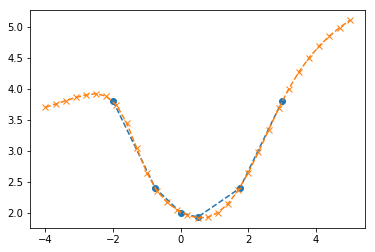

In [7]:
#  Plot cross sections model

predict_X = np.linspace(train_X[0]-2., train_X[-1]+2., 31)
predict_Y = xsec_model.predict(predict_X)
model_xsections = {mu:xsec_model.predict([mu])[0] for mu in mu_scan_points}

plt.plot(mu_scan_points, train_Y  , "o--")
plt.plot(predict_X     , predict_Y, "x--")
plt.show()

In [8]:
def flat_noise_model (self, x, c, **kwargs) :
    if hasattr(self, "return_value") == False :
        A_lims = [50, 250]
        B_lims = [50, 500]
        C_lims = [-1.*np.pi, np.pi]
        A_range = A_lims[1] - A_lims[0]
        B_range = B_lims[1] - B_lims[0]
        C_range = C_lims[1] - C_lims[0]
        self.return_value = 1. / np.fabs(A_range*B_range*C_range)
    return self.return_value

def rotated_noise_model (self, x, c, **kwargs) :
    if hasattr(self, "whitening_params") == False :
        if "whitening_params" not in kwargs :
            raise RuntimeError("No whitening parameters saved or provided")
    if "whitening_params" in kwargs :
        self.whitening_params = kwargs.get("whitening_params")
    whitening_params = self.whitening_params
    white_x = whiten_data ([x], params=whitening_params) [0]
    return np.prod([stats.norm.pdf(i) for i in white_x])

class NoiseModel :
    def clear (self) :
        self.name  = ""
        self.model = None
    def evaluate (self, x, c, **kwargs) :
        if type(self.model) == type(None) :
            raise RuntimeError(f"Cannot evaluate PDF - no function set")
        return self.model(self, x, c, **kwargs)
    @classmethod
    def from_noise_and_model (cls, noise, disc, new_name="", **kwargs) :
        def new_model (self, x, c, *argv, **kwargs) :
            f = noise.evaluate(x, c, **kwargs)
            D = disc.predict(np.array([x], [c]))[0,0]
            return D * f / (1.-D)
        return cls(new_name, new_model)
    def __init__ (self, name="", model=None) :
        self.clear()
        self.name  = name
        self.model = model
        
FlatNoiseModel = NoiseModel("NoiseModel1", flat_noise_model)

chosen_noise_model = FlatNoiseModel

In [9]:
#  Brief:  use NoiseModel or ContrastiveModel to generate weights for pre-existing datapoints
#
def generate_weights (x, c, model1, model2) :
    weights = []
    for xp, cp in zip(x, c) :
        w = model2.evaluate(xp, cp) / model1.evaluate(xp, cp)
        if np.isnan(w) : w = 0.
        if np.isinf(w) : w = 1.
        weights.append(w)
    return weights


#  Brief:  alternative: store old weights in a vector, so we don't have to re-evaluate them every time
#
def update_weights (old_weights, new_model) :
    if type(old_weights) != type(new_model) :
        raise TypeError(f"old_weights type {type(old_weights)} does not match new_model type {type(new_model)}")
    if type(old_weights) == dict :
        weights = {}
        for key in old_weights :
            weights [key] = update_weights(old_weights[key], new_model[key])
        return weights
    weights = []
    for old_weight, new_f in zip(old_weights, new_model) :
        w = new_f / old_weight
        if np.isnan(w) : w = 0.
        if np.isinf(w) : w = 1.
        weights.append(w)
    return weights


#  Brief:  update model values
#
def update_model_values (mu_scan_points, x, old_values, disc) :
    new_values = {}
    for mu in mu_scan_points :
        xp = x[mu]
        cp = np.full(fill_value=mu, shape=(len(xp),))
        D = disc.predict([xp, cp])[:,0]
        new_values [mu] = D * old_values[mu] / (1.-D)
    return new_values

In [10]:
def iterate (mu_scan_points,
             noise_f_N, 
             learn_datapoints, 
             learn_weights,
             n_train_points_per_c_per_ds_true,
             noise_datapoints, 
             noise_weights,
             n_train_points_per_c_per_ds_fake,
             initial_noise_weights,
             disc=None, 
             initial_noise_fraction=0) :
    
    print("Compiling training dataset")
    train_DS_true, train_condition_true, train_weights_true = [], [], []
    for mu in mu_scan_points :
        train_dataset_mu = learn_datapoints [mu]
        random_indices   = np.random.randint(0, train_dataset_mu.shape[0], n_train_points_per_c_per_ds_true)
        train_DS         = train_dataset_mu [random_indices,:]
        train_weights    = learn_weights [mu] [random_indices]
        train_weights    = train_weights / np.sum(train_weights)
        train_DS_true       .append(train_DS)
        train_weights_true  .append(train_weights)
        train_condition_true.append(np.full(fill_value=mu, shape=train_weights.shape))
    train_DS_true, train_condition_true, train_weights_true = np.concatenate(train_DS_true), np.concatenate(train_condition_true), np.concatenate(train_weights_true)
    
    print("Compiling noise dataset")
    for mu in mu_scan_points :
        print(f"{len(noise_weights[mu])} noise datapoints provided for mu = {mu:.4f}")
        print(f"-  {100.*len([1 for xp in noise_weights[mu]/np.mean(noise_weights[mu]) if xp > 0.01])/len(noise_weights[mu]):.2f}% are useful (weight is > 1% of the mean)")
    
    noise_weights_updated = noise_weights
    if initial_noise_fraction > 0 :
        print(f"Adding {100.*initial_noise_fraction:.2f}% of initial noise back in")
        for mu in mu_scan_points :
            noise_weights_updated[mu] = noise_weights_updated[mu] + initial_noise_fraction*initial_noise_weights[mu]
            noise_weights_updated[mu] = noise_weights_updated[mu] / np.sum(noise_weights_updated[mu])
    
    train_DS_fake, train_condition_fake, train_weights_fake = [], [], []
    for mu in mu_scan_points :
        noise_dataset_mu = noise_datapoints [mu]
        noise_weights_mu = noise_weights_updated [mu]
        random_indices   = np.random.choice(len(noise_dataset_mu), n_train_points_per_c_per_ds_fake, p=noise_weights_mu)
        train_DS         = noise_dataset_mu  [random_indices,:]
        train_weights    = np.full(shape=(n_train_points_per_c_per_ds_fake,), fill_value=1./n_train_points_per_c_per_ds_fake)
        train_DS_fake       .append(train_DS)
        train_weights_fake  .append(train_weights)
        train_condition_fake.append(np.full(fill_value=mu, shape=train_weights.shape))
    train_DS_fake, train_condition_fake, train_weights_fake = np.concatenate(train_DS_fake), np.concatenate(train_condition_fake), np.concatenate(train_weights_fake)
    
    print(train_DS_true.shape)
    print(train_condition_true.shape)
    print(train_weights_true.shape)
    print(train_DS_fake.shape)
    print(train_condition_fake.shape)
    print(train_weights_fake.shape)

    print("Creating labels")
    labels_true = np.array([1. for i in range(len(train_DS_true))])
    labels_fake = np.array([0. for i in range(len(train_DS_fake))])

    print("Creating trainable data")
    train_data    = np.concatenate([train_DS_true       , train_DS_fake       ])
    train_cond    = np.concatenate([train_condition_true, train_condition_fake])
    train_labels  = np.concatenate([labels_true         , labels_fake         ])
    train_weights = np.concatenate([train_weights_true  , train_weights_fake  ])
    train_data, train_cond, train_labels, train_weights = joint_shuffle(train_data, train_cond, train_labels, train_weights)
    
    if type(disc) == type(None) :
        print("Creating discriminator")
        disc = models.create_conditional_discriminator (dropout         = dropout,
                                                        num_categories  = 1,
                                                        num_conditions  = 1,
                                                        num_observables = 3,
                                                        batch_norm      = False,
                                                        data_layers      = network_data_layers,
                                                        condition_layers = network_condition_layers,
                                                        combined_layers  = network_combined_layers)
        


    history = disc.fit([train_data, train_cond], 
                       train_labels,
                       sample_weight=train_weights,
                       validation_split = 0.3,
                       callbacks = [EarlyStopping(patience=stopping_patience, 
                                                  restore_best_weights=True,
                                                  monitor="val_loss")],
                       epochs=max_epochs,
                       shuffle=True,
                       batch_size=train_batch_size)
    
    noise_f_new       = update_model_values(mu_scan_points, noise_datapoints, noise_f_N, disc)    
    noise_weights_new = {}
    for mu in mu_scan_points :
        noise_weights_new [mu] = noise_f_new [mu] / initial_noise_weights [mu]  #   update_weights(noise_datapoints, noise_weights_N, noise_f_new)
        noise_weights_new [mu] = noise_weights_new [mu] / np.sum(noise_weights_new[mu])
    
    return noise_f_new, noise_weights_new, disc


Noise datapoints for scan point -2.0 with shape (100000, 3)
Noise weights for scan point -2.0 with shape (100000,)
Noise datapoints for scan point -0.75 with shape (100000, 3)
Noise weights for scan point -0.75 with shape (100000,)
Noise datapoints for scan point 0.0 with shape (100000, 3)
Noise weights for scan point 0.0 with shape (100000,)
Noise datapoints for scan point 0.5 with shape (100000, 3)
Noise weights for scan point 0.5 with shape (100000,)
Noise datapoints for scan point 1.75 with shape (100000, 3)
Noise weights for scan point 1.75 with shape (100000,)
Noise datapoints for scan point 3.0 with shape (100000, 3)
Noise weights for scan point 3.0 with shape (100000,)


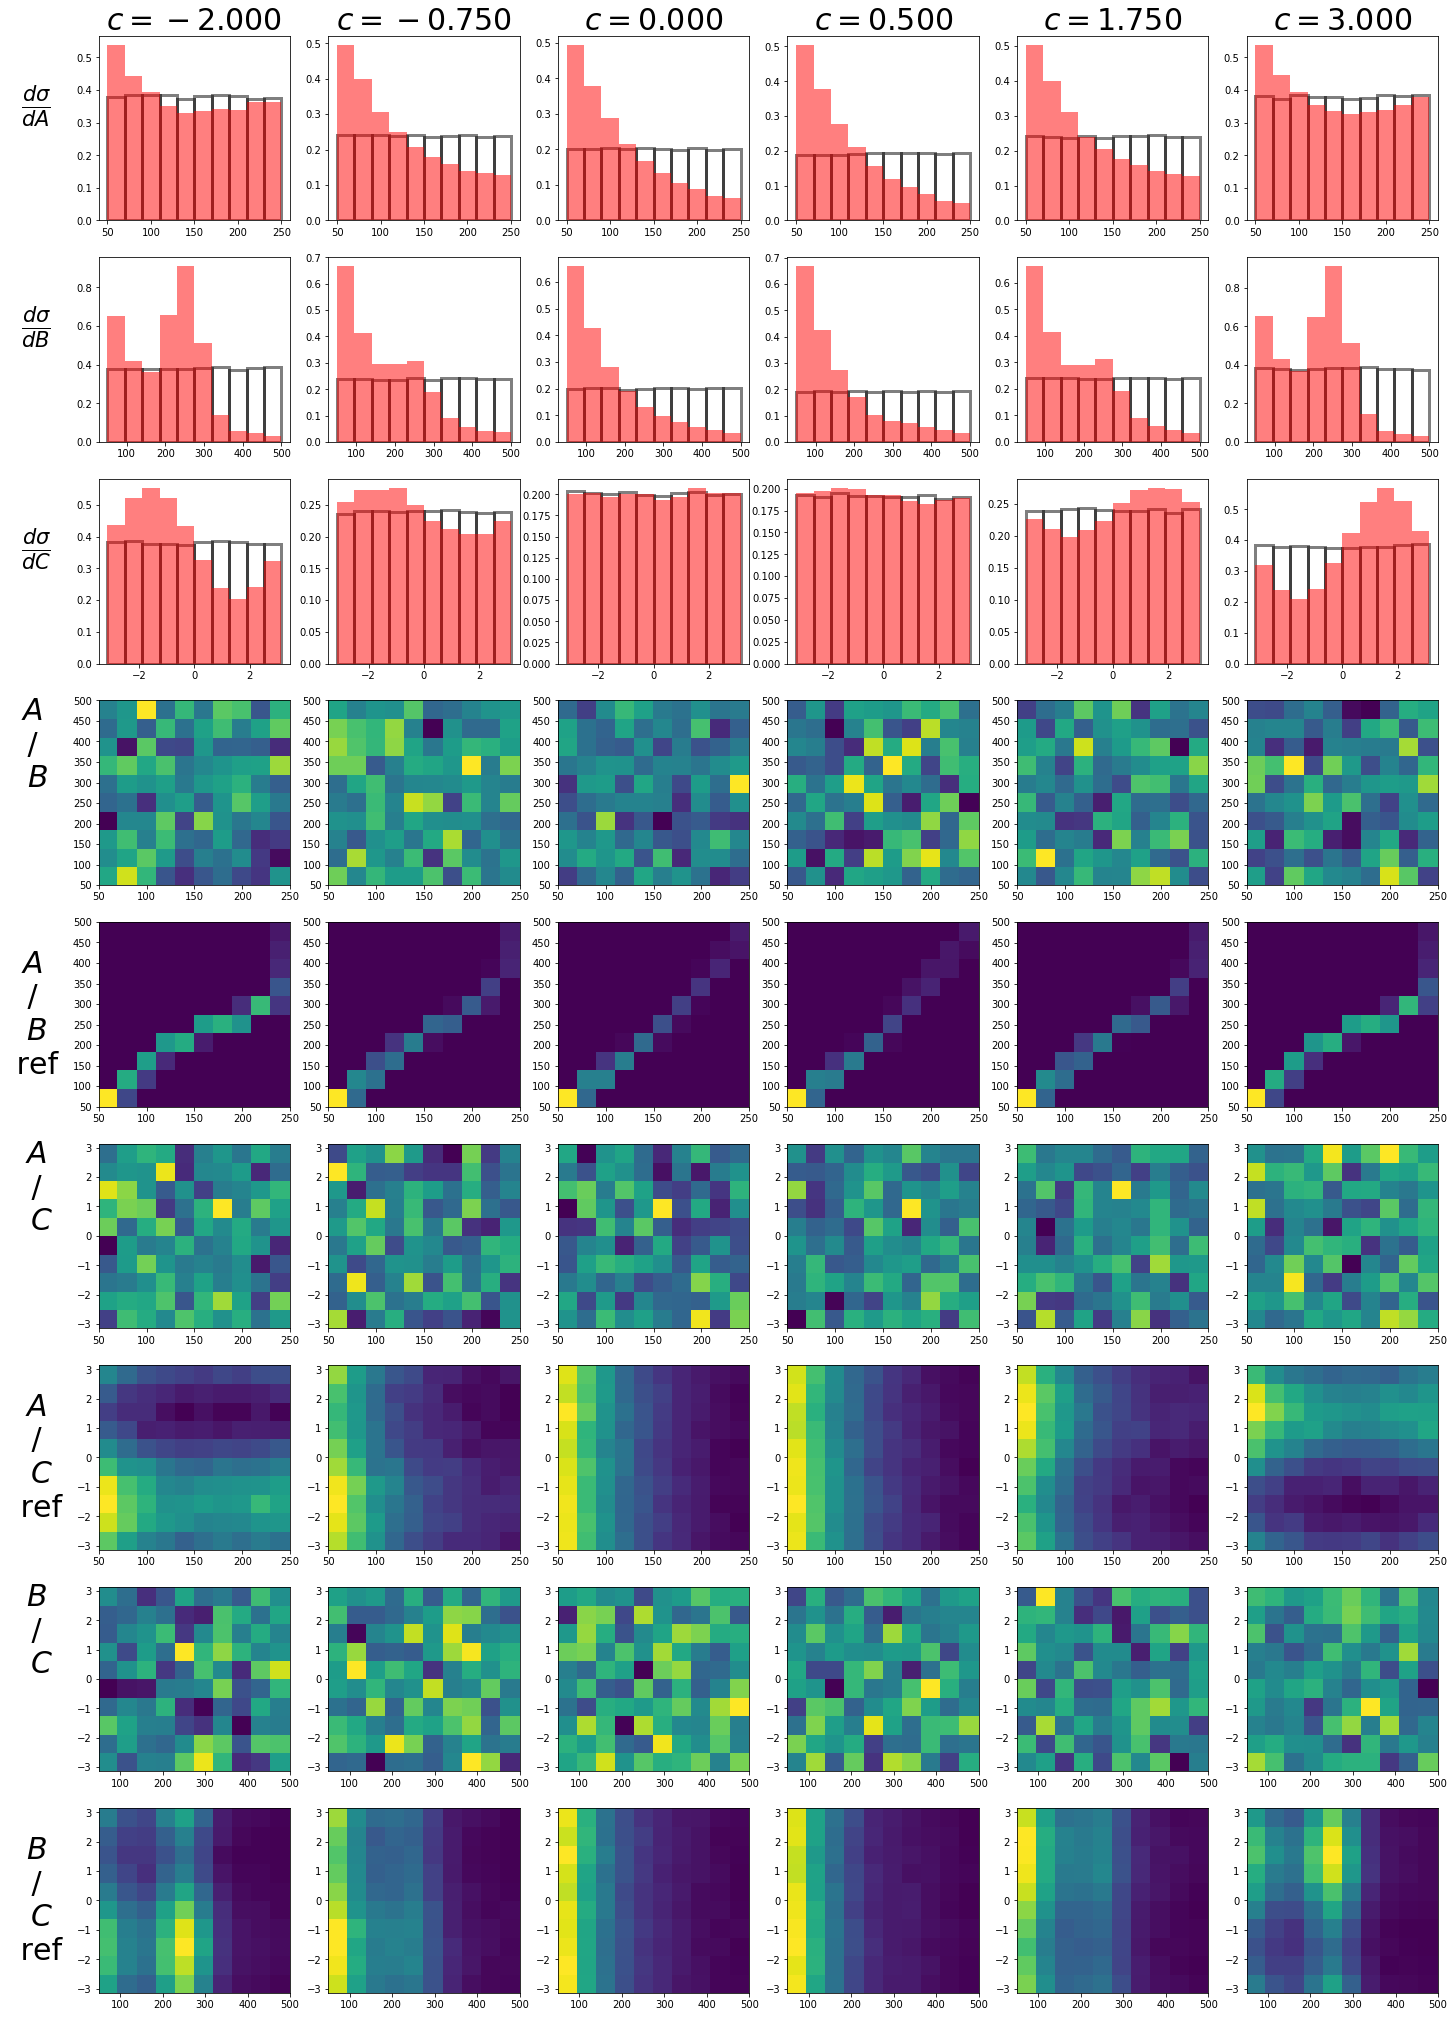

In [11]:
#  Generate initial noise dataset

noise_datasets, noise_weights = {}, {}
for mu in mu_scan_points :
    dataset = []
    uniform_A_values = np.random.uniform(50       , 250  , n_noise_points_per_c_per_ds)
    uniform_B_values = np.random.uniform(50       , 500  , n_noise_points_per_c_per_ds)
    uniform_C_values = np.random.uniform(-1.*np.pi, np.pi, n_noise_points_per_c_per_ds)
    noise_datasets [mu]    = np.array([uniform_A_values, uniform_B_values, uniform_C_values]).transpose()
    noise_datasets [mu], _ = whiten_data (noise_datasets[mu], params=whitening_params)
    noise_weights  [mu]    = np.array([chosen_noise_model.evaluate(x, np.full(fill_value=mu,shape=(len(x),))) for x in noise_datasets[mu]])
    noise_weights  [mu]    = noise_weights[mu] / np.sum(noise_weights[mu])
    print(f"Noise datapoints for scan point {mu} with shape {noise_datasets[mu].shape}")
    print(f"Noise weights for scan point {mu} with shape {noise_weights[mu].shape}")

plot_dataset(mu_scan_points, 
             model_xsections, unwhiten_data(noise_datasets, params=whitening_params), noise_weights, 
             ref=(xsections, datasets, weights)) 


Compiling training dataset
Compiling noise dataset
100000 noise datapoints provided for mu = -2.0000
-  100.00% are useful (weight is > 1% of the mean)
100000 noise datapoints provided for mu = -0.7500
-  100.00% are useful (weight is > 1% of the mean)
100000 noise datapoints provided for mu = 0.0000
-  100.00% are useful (weight is > 1% of the mean)
100000 noise datapoints provided for mu = 0.5000
-  100.00% are useful (weight is > 1% of the mean)
100000 noise datapoints provided for mu = 1.7500
-  100.00% are useful (weight is > 1% of the mean)
100000 noise datapoints provided for mu = 3.0000
-  100.00% are useful (weight is > 1% of the mean)
Adding 5.00% of initial noise back in
(300000, 3)
(300000,)
(300000,)
(600000, 3)
(600000,)
(600000,)
Creating labels
Creating trainable data
Creating discriminator
Creating discriminator with 3 observables and 1 conditions
Model: "Discriminator"
__________________________________________________________________________________________________
L

Epoch 21/1000
630000/630000 [==============================] - 2s 3us/step - loss: 4.7661e-08 - val_loss: 2.3617e-08
Epoch 22/1000
630000/630000 [==============================] - 2s 3us/step - loss: 4.1597e-08 - val_loss: 2.0608e-08
Epoch 23/1000
630000/630000 [==============================] - 2s 3us/step - loss: 3.9237e-08 - val_loss: 1.8137e-08
Epoch 24/1000
630000/630000 [==============================] - 2s 3us/step - loss: 3.3992e-08 - val_loss: 1.6044e-08
Epoch 25/1000
630000/630000 [==============================] - 2s 3us/step - loss: 3.2373e-08 - val_loss: 1.4230e-08
Epoch 26/1000
630000/630000 [==============================] - 2s 3us/step - loss: 2.9354e-08 - val_loss: 1.2864e-08
Epoch 27/1000
630000/630000 [==============================] - 2s 3us/step - loss: 2.7441e-08 - val_loss: 1.1646e-08
Epoch 28/1000
630000/630000 [==============================] - 2s 3us/step - loss: 2.5977e-08 - val_loss: 1.0643e-08
Epoch 29/1000
630000/630000 [==============================] - 2

630000/630000 [==============================] - 2s 3us/step - loss: 2.2329e-09 - val_loss: 4.8468e-10
Epoch 92/1000
630000/630000 [==============================] - 2s 3us/step - loss: 2.5706e-09 - val_loss: 4.7127e-10
Epoch 93/1000
630000/630000 [==============================] - 2s 3us/step - loss: 2.1917e-09 - val_loss: 4.5710e-10
Epoch 94/1000
630000/630000 [==============================] - 2s 3us/step - loss: 2.7989e-09 - val_loss: 4.4155e-10
Epoch 95/1000
630000/630000 [==============================] - 2s 3us/step - loss: 2.2398e-09 - val_loss: 4.2809e-10
Epoch 96/1000
630000/630000 [==============================] - 2s 3us/step - loss: 2.1902e-09 - val_loss: 4.1842e-10
Epoch 97/1000
630000/630000 [==============================] - 2s 3us/step - loss: 2.1957e-09 - val_loss: 4.0537e-10
Epoch 98/1000
630000/630000 [==============================] - 2s 3us/step - loss: 1.9645e-09 - val_loss: 3.9303e-10
Epoch 99/1000
630000/630000 [==============================] - 2s 3us/step - l

630000/630000 [==============================] - 2s 3us/step - loss: 4.6927e-10 - val_loss: 4.7718e-11
Epoch 230/1000
630000/630000 [==============================] - 2s 3us/step - loss: 5.0468e-10 - val_loss: 4.7076e-11
Epoch 231/1000
630000/630000 [==============================] - 2s 3us/step - loss: 5.0963e-10 - val_loss: 4.6457e-11
Epoch 232/1000
630000/630000 [==============================] - 2s 3us/step - loss: 4.8600e-10 - val_loss: 4.5789e-11
Epoch 233/1000
630000/630000 [==============================] - 2s 3us/step - loss: 4.5261e-10 - val_loss: 4.5185e-11
Epoch 234/1000
630000/630000 [==============================] - 2s 3us/step - loss: 5.5047e-10 - val_loss: 4.4728e-11
Epoch 235/1000
630000/630000 [==============================] - 2s 3us/step - loss: 4.5208e-10 - val_loss: 4.4149e-11
Epoch 236/1000
630000/630000 [==============================] - 2s 3us/step - loss: 5.5656e-10 - val_loss: 4.3616e-11
Epoch 237/1000
630000/630000 [==============================] - 3s 4us/

630000/630000 [==============================] - 2s 3us/step - loss: 4.6970e-10 - val_loss: 1.5394e-11
Epoch 368/1000
630000/630000 [==============================] - 2s 3us/step - loss: 5.0656e-10 - val_loss: 1.5954e-11
Epoch 369/1000
630000/630000 [==============================] - 2s 3us/step - loss: 2.3761e-10 - val_loss: 1.5881e-11
Epoch 370/1000
630000/630000 [==============================] - 2s 3us/step - loss: 2.1458e-10 - val_loss: 1.5750e-11
Epoch 371/1000
630000/630000 [==============================] - 2s 3us/step - loss: 2.4023e-10 - val_loss: 1.5620e-11
Epoch 372/1000
630000/630000 [==============================] - 2s 3us/step - loss: 2.6143e-10 - val_loss: 1.5538e-11
Epoch 373/1000
630000/630000 [==============================] - 2s 3us/step - loss: 3.3279e-10 - val_loss: 1.5451e-11
Epoch 374/1000
630000/630000 [==============================] - 2s 3us/step - loss: 4.9119e-10 - val_loss: 1.5508e-11
Epoch 375/1000
630000/630000 [==============================] - 2s 3us/

630000/630000 [==============================] - 2s 3us/step - loss: 2.6438e-10 - val_loss: 8.1847e-12
Epoch 506/1000
630000/630000 [==============================] - 2s 3us/step - loss: 1.6877e-10 - val_loss: 8.1646e-12
Epoch 507/1000
630000/630000 [==============================] - 2s 3us/step - loss: 1.4636e-10 - val_loss: 8.1266e-12
Epoch 508/1000
630000/630000 [==============================] - 2s 3us/step - loss: 1.6403e-10 - val_loss: 8.0862e-12
Epoch 509/1000
630000/630000 [==============================] - 2s 3us/step - loss: 1.7625e-10 - val_loss: 8.0955e-12
Epoch 510/1000
630000/630000 [==============================] - 2s 3us/step - loss: 1.4518e-10 - val_loss: 8.0734e-12
Epoch 511/1000
630000/630000 [==============================] - 2s 3us/step - loss: 1.4895e-10 - val_loss: 8.0450e-12
Epoch 512/1000
630000/630000 [==============================] - 2s 3us/step - loss: 1.3919e-10 - val_loss: 8.0038e-12
Epoch 513/1000
630000/630000 [==============================] - 2s 3us/

630000/630000 [==============================] - 2s 3us/step - loss: 1.0300e-10 - val_loss: 5.2406e-12
Epoch 644/1000
630000/630000 [==============================] - 2s 3us/step - loss: 9.6983e-11 - val_loss: 5.2213e-12
Epoch 645/1000
630000/630000 [==============================] - 2s 3us/step - loss: 1.0362e-10 - val_loss: 5.2023e-12
Epoch 646/1000
630000/630000 [==============================] - 2s 3us/step - loss: 1.0199e-10 - val_loss: 5.1845e-12
Epoch 647/1000
630000/630000 [==============================] - 2s 3us/step - loss: 9.7692e-11 - val_loss: 5.1654e-12
Epoch 648/1000
630000/630000 [==============================] - 2s 3us/step - loss: 1.0030e-10 - val_loss: 5.1472e-12
Epoch 649/1000
630000/630000 [==============================] - 2s 3us/step - loss: 2.5762e-10 - val_loss: 5.1900e-12
Epoch 650/1000
630000/630000 [==============================] - 2s 3us/step - loss: 1.0072e-10 - val_loss: 5.1864e-12
Epoch 651/1000
630000/630000 [==============================] - 2s 3us/

630000/630000 [==============================] - 2s 3us/step - loss: 1.7794e-10 - val_loss: 3.7938e-12
Epoch 782/1000
630000/630000 [==============================] - 2s 3us/step - loss: 8.7877e-11 - val_loss: 3.7924e-12
Epoch 783/1000
630000/630000 [==============================] - 2s 3us/step - loss: 9.2337e-11 - val_loss: 3.7847e-12
Epoch 784/1000
630000/630000 [==============================] - 2s 3us/step - loss: 1.9644e-10 - val_loss: 3.7951e-12
Epoch 785/1000
630000/630000 [==============================] - 2s 3us/step - loss: 5.9526e-10 - val_loss: 3.7977e-12
Epoch 786/1000
630000/630000 [==============================] - 2s 3us/step - loss: 1.0872e-10 - val_loss: 3.7908e-12
Epoch 787/1000
630000/630000 [==============================] - 2s 3us/step - loss: 7.8259e-11 - val_loss: 3.7838e-12
Epoch 788/1000
630000/630000 [==============================] - 2s 3us/step - loss: 9.5323e-11 - val_loss: 3.7757e-12
Epoch 789/1000
630000/630000 [==============================] - 2s 3us/

630000/630000 [==============================] - 2s 3us/step - loss: 7.2812e-11 - val_loss: 3.1709e-12
Epoch 920/1000
630000/630000 [==============================] - 2s 3us/step - loss: 7.9911e-11 - val_loss: 3.1675e-12
Epoch 921/1000
630000/630000 [==============================] - 2s 3us/step - loss: 6.5856e-11 - val_loss: 3.1615e-12
Epoch 922/1000
630000/630000 [==============================] - 2s 3us/step - loss: 6.8421e-11 - val_loss: 3.1557e-12
Epoch 923/1000
630000/630000 [==============================] - 2s 3us/step - loss: 6.5051e-11 - val_loss: 3.1495e-12
Epoch 924/1000
630000/630000 [==============================] - 2s 3us/step - loss: 8.7686e-11 - val_loss: 3.1452e-12
Epoch 925/1000
630000/630000 [==============================] - 2s 3us/step - loss: 6.9102e-11 - val_loss: 3.1397e-12
Epoch 926/1000
630000/630000 [==============================] - 2s 3us/step - loss: 6.6664e-11 - val_loss: 3.1338e-12
Epoch 927/1000
630000/630000 [==============================] - 2s 3us/

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/usr/local/lib/python3.7/site-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


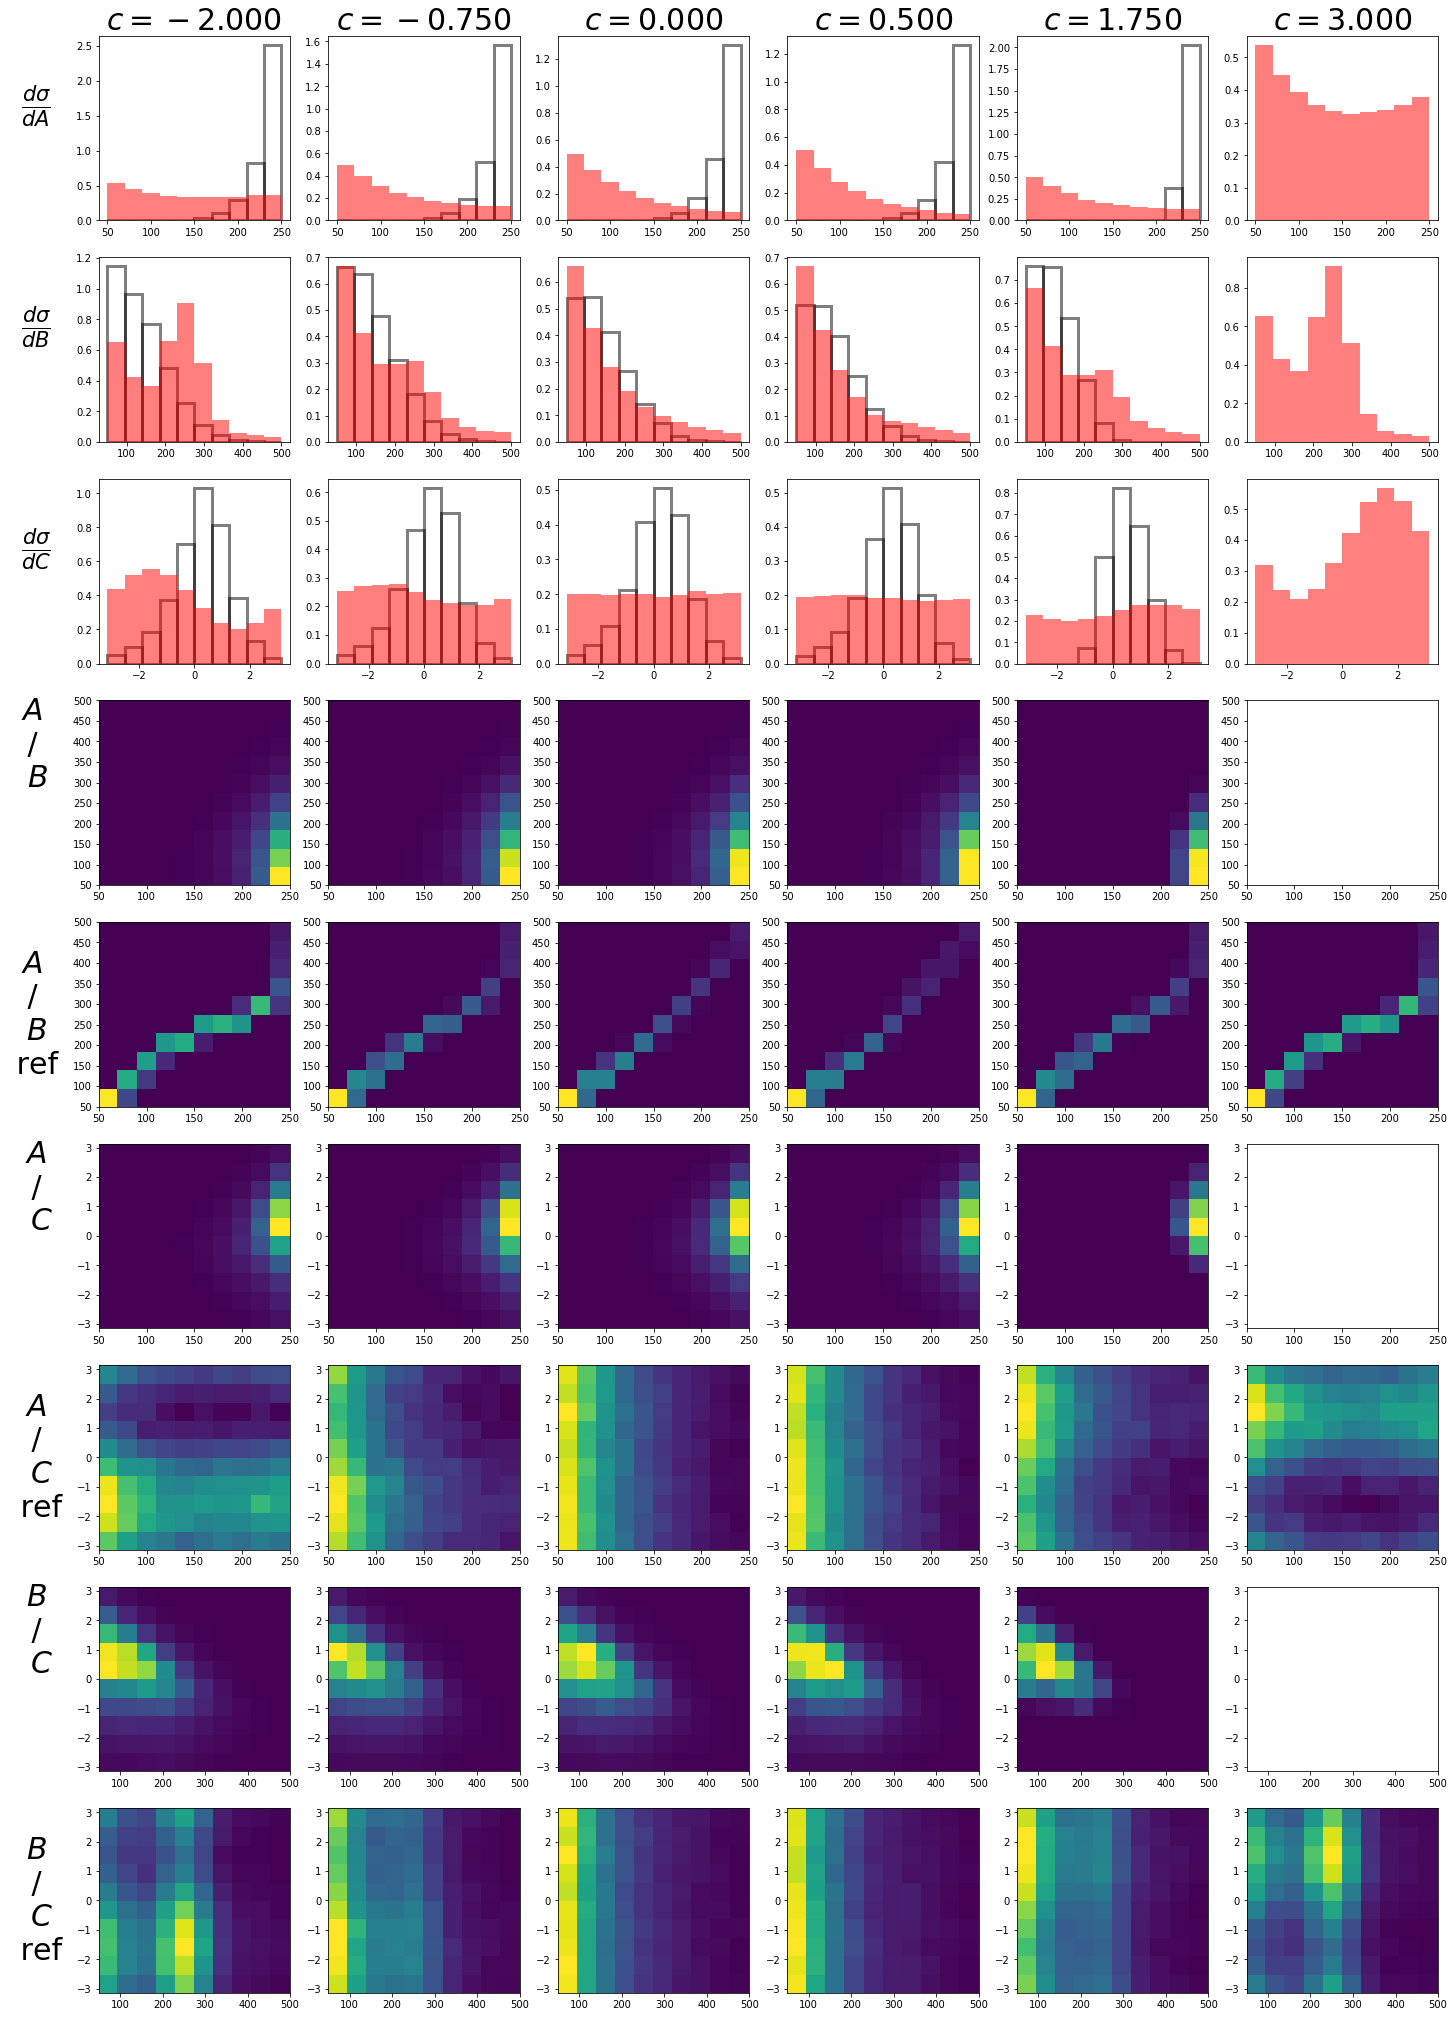

Compiling training dataset
Compiling noise dataset
100000 noise datapoints provided for mu = -2.0000
-  20.71% are useful (weight is > 1% of the mean)
100000 noise datapoints provided for mu = -0.7500
-  30.95% are useful (weight is > 1% of the mean)
100000 noise datapoints provided for mu = 0.0000
-  31.09% are useful (weight is > 1% of the mean)
100000 noise datapoints provided for mu = 0.5000
-  23.89% are useful (weight is > 1% of the mean)
100000 noise datapoints provided for mu = 1.7500
-  1.53% are useful (weight is > 1% of the mean)
100000 noise datapoints provided for mu = 3.0000
-  0.00% are useful (weight is > 1% of the mean)
Adding 5.00% of initial noise back in


ValueError: probabilities contain NaN

In [12]:
times_N = [0]

prev_noise_weights = noise_weights

prev_f = {}
for mu in mu_scan_points :
    prev_f [mu] = np.array([chosen_noise_model.evaluate(x, np.full(fill_value=mu,shape=(len(x),))) for x in noise_datasets[mu]])
disc = None

start_time = time.time()

for iteration in range(num_SCE_iterations) :
    if iterate_same_network is False : disc = None
    prev_f, prev_noise_weights, disc = iterate (mu_scan_points,
                                                prev_f, 
                                                datasets, 
                                                weights,
                                                n_train_points_per_c_per_ds_true,
                                                noise_datasets, 
                                                prev_noise_weights,
                                                n_train_points_per_c_per_ds_fake,
                                                noise_weights,
                                                disc, 
                                                initial_noise_fraction=initial_noise_fraction)
    
    times_N.append(time.time() - start_time)
    
    plot_dataset(mu_scan_points, 
                 model_xsections, unwhiten_data(noise_datasets, params=whitening_params), prev_noise_weights, 
                 ref=(xsections, datasets, weights)) 
    
    